# XGBoost with variable combinations:

Trains an XGBoost model for all variable combinations to find the best combinations of temperature and total precipitation.

## Setting up:
### Imports:

In [1]:

from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
import re
import warnings
import re
import seaborn as sns
import itertools
from ast import literal_eval
import matplotlib

import math
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from scripts.xgb_helpers import *
from scripts.stakes_processing import *
from scripts.xgb_input import *
from scripts.xgb_model import *
from scripts.plots_clean import *
from scripts.xgb_metrics import *
from scripts.xgb_model_varcomb import *

from scripts.PDD_model_modules import *
from scripts.PDD_model_calibration import *
from scripts.PDD_helpers import *

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2


### Constants:

In [2]:
# set seed everywhere:
seed_all(SEED)
print('Seed:', SEED)

param_grid = {
    'learning_rate': np.arange(0.01, 0.2, 0.01),
    'n_estimators': np.arange(50, 300, 15),
    'max_depth': np.arange(3, 10, 1),
}

feature_list = [
    't2m_Oct', 't2m_Nov', 't2m_Dec', 't2m_Jan', 't2m_Feb', 't2m_Mar',
    't2m_Apr', 't2m_May', 't2m_June', 't2m_July', 't2m_Aug', 't2m_Sep',
    'tp_Oct', 'tp_Nov', 'tp_Dec', 'tp_Jan', 'tp_Feb', 'tp_Mar', 'tp_Apr',
    'tp_May', 'tp_June', 'tp_July', 'tp_Aug', 'tp_Sep'
]

color_palette = sns.color_palette("husl", 13)
colors = np.tile("#8CA6D9", 6)
palette_grays = sns.color_palette(colors)

INPUT_TYPE = "MeteoSuisse"

KFOLD = True
if KFOLD:
    NUM_FOLDS = 5
    FOLD = 'kfold'
else:
    NUM_FOLDS = 1
    FOLD = 'single_fold'

path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

Seed: 5


## Pre-processing:

In [3]:
# Get number of stakes per glacier and their names
glStakesNum, glStakes = get_StakesNum(path_GLAMOS_csv)
glStakes_sorted = sorted(glStakesNum.items(), key=lambda x: x[1])

# Get total number of stakes
num_stakes = 0
for (glacier, num) in (glStakes_sorted):
    num_stakes += num
print('Total number of stakes:', num_stakes)
print('Number of stakes per glacier:\n', glStakes_sorted)

# glacier names:
glaciers = list(glStakes.keys())
# Keep only the glaciers with more than 20 years of measurements
glStakes_20years, glStakes_20years_sorted, glStakes_20years_all = getStakesNyears(
    glaciers,
    glStakes,
    path_glacattr,
    path_era5_stakes,
    input_type=INPUT_TYPE,
    N=20)
print('After preprocessing:\n----\nNumber of glaciers:',
      len(glStakes_20years.keys()))
# num_stakes = 0
# for gl in glStakes_20years.keys():
#     num_stakes += len(glStakes_20years[gl])
print('Number of stakes:', len(glStakes_20years_all))

Total number of stakes: 46
Number of stakes per glacier:
 [('sanktanna', 1), ('adler', 1), ('schwarzberg', 1), ('plainemorte', 1), ('allalin', 1), ('hohlaub', 1), ('corbassiere', 1), ('tsanfleuron', 2), ('gries', 2), ('pizol', 2), ('clariden', 2), ('pers', 2), ('murtel', 2), ('plattalva', 2), ('basodino', 3), ('rhone', 3), ('limmern', 3), ('silvretta', 3), ('gietro', 3), ('findelen', 4), ('aletsch', 6)]
1991 2023
1991 2023
1991 2023
2011 2023
2004 2023
2004 2023
2004 2023
2004 2023
2005 2023
2009 2023
2009 2023
1961 2023
1961 2023
2006 2023
2006 2023
2006 2023
1955 2023
Missing years: [2016, 2017, 2018, 2019, 2020]
1920 2023
1995 2023
1920 2023
1920 2023
1920 2023
1920 2023
1948 1984
1948 1984
1948 1984
2006 2021
2006 2021
2009 2023
1914 2023
1914 2023
1955 2023
1914 2023
1914 2023
1914 2023
1955 2023
2001 2023
2001 2023
2012 2023
2012 2023
1996 2023
1948 1984
1948 1984
1966 2023
1966 2023
1966 2023
After preprocessing:
----
Number of glaciers: 13
Number of stakes: 28


In [4]:
# Rename stakes so that ordered by elevation from P1 to P(X highest):
glaciers = list(glStakes_20years.keys())
s_end, gl_mb, = {}, {}
start_years, end_years = [], []
stakes_per_el = {}
var = "b_a_fix"
for g in range(len(glaciers)):
    gl = glaciers[g]  # One glacier
    height = {}
    for stake in glStakes_20years[gl]:
        # Get coordinates and time of file for this stake:
        fileName = re.split(".csv", stake)[0][:-3]
        df_stake = read_stake_csv(path_glacattr, stake,
                                  COI).sort_values(by="date_fix0")

        # remove category 0
        df_stake = df_stake[df_stake.vaw_id > 0]

        # remove 2021:
        df_stake = df_stake[df_stake.date_fix0.dt.year < 2021]

        # years:
        years = [
            df_stake.date_fix0.iloc[i].year
            for i in range(len(df_stake.date_fix0))
        ]

        start_years.append(years[0])
        end_years.append(years[-1])

        s_end[fileName] = years  # start and end years
        gl_mb[fileName] = df_stake[var].values / (
            1000)  # MB of stake (change to m w.e.)
        height[fileName] = df_stake.height.iloc[0]  # Height of stake

    # Sort stakes per elevation
    print(height)
    stakes_per_el[gl] = list(
        pd.Series(height).sort_values(ascending=True).index.values)
rename_stakes = {}
for gl in stakes_per_el.keys():
    for i, stake in enumerate(stakes_per_el[gl]):
        rename_stakes[stake] = f"{GLACIER_CORRECT[gl]}-P{i+1}"

rename_stakes

{'basodino_P5': 2886.7744920000005, 'basodino_P8': 3116.2885880000003, 'basodino_P10': 2759.6606536000004}
{'gries_P32': 2654.0219294000003, 'gries_P112': 3101.4990409200004}
{'schwarzberg_P2': 2815.49513372}
{'aletsch_P5': 3526.320971, 'aletsch_P0': 2089.50294328, 'aletsch_P9': 2989.76978664, 'aletsch_P10': 2906.3757971200007, 'aletsch_P3': 3380.745516}
{'limmern_P2': 2641.7760650000005, 'limmern_P1': 2514.5717416, 'limmern_P3': 2848.991556}
{'clariden_U': 2945.80231296, 'clariden_L': 2743.35311232}
{'allalin_P1': 2897.44286848}
{'silvretta_P9': 2586.799167, 'silvretta_BO': 3054.78944116, 'silvretta_BU': 2812.58672904}
{'hohlaub_P2': 3078.1231082000004}
{'pers_P24': 2891.33369724}
{'corbassiere_B2': 2711.9036606400005}
{'plattalva_P10': 2859.3380456000004, 'plattalva_P11': 2850.831543}
{'gietro_P1': 3373.93588476, 'gietro_P3': 2858.10703112, 'gietro_P5': 3128.1982310800004}


{'basodino_P10': 'Basodino-P1',
 'basodino_P5': 'Basodino-P2',
 'basodino_P8': 'Basodino-P3',
 'gries_P32': 'Gries-P1',
 'gries_P112': 'Gries-P2',
 'schwarzberg_P2': 'Schwarzberg-P1',
 'aletsch_P0': 'Aletsch-P1',
 'aletsch_P10': 'Aletsch-P2',
 'aletsch_P9': 'Aletsch-P3',
 'aletsch_P3': 'Aletsch-P4',
 'aletsch_P5': 'Aletsch-P5',
 'limmern_P1': 'Limmern-P1',
 'limmern_P2': 'Limmern-P2',
 'limmern_P3': 'Limmern-P3',
 'clariden_L': 'Clariden-P1',
 'clariden_U': 'Clariden-P2',
 'allalin_P1': 'Allalin-P1',
 'silvretta_P9': 'Silvretta-P1',
 'silvretta_BU': 'Silvretta-P2',
 'silvretta_BO': 'Silvretta-P3',
 'hohlaub_P2': 'Hohlaub-P1',
 'pers_P24': 'Pers-P1',
 'corbassiere_B2': 'Corbassiere-P1',
 'plattalva_P11': 'Plattalva-P1',
 'plattalva_P10': 'Plattalva-P2',
 'gietro_P3': 'Gietro-P1',
 'gietro_P5': 'Gietro-P2',
 'gietro_P1': 'Gietro-P3'}

## XGBoost - run multi combinations:

In [5]:
# temperature variables
t2m_vars = [
    't2m_Oct',
    't2m_Nov',
    't2m_Dec',
    't2m_Jan',
    't2m_Feb',
    't2m_Mar',
    't2m_Apr',
    't2m_May',
    't2m_June',
    't2m_July',
    't2m_Aug',
    't2m_Sep',
]
# precipitation variables
tp_vars = [
    'tp_Oct',
    'tp_Nov',
    'tp_Dec',
    'tp_Jan',
    'tp_Feb',
    'tp_Mar',
    'tp_Apr',
    'tp_May',
    'tp_June',
    'tp_July',
    'tp_Aug',
    'tp_Sep',
]

In [6]:
# Get all combinations of months: (powerset so not consecutive)
def powerset(original_list):
    # The number of subsets is 2^n
    num_subsets = 2**len(original_list)

    # Create an empty list to hold all the subsets
    subsets = []

    # Iterate over all possible subsets
    for subset_index in range(num_subsets):
        # Create an empty list to hold the current subset
        subset = []
        # Iterate over all elements in the original list
        for index in range(len(original_list)):
            # Check if index bit is set in subset_index
            if (subset_index & (1 << index)) != 0:
                # If the bit is set, add the element at this index to the current subset
                subset.append(original_list[index])
        # Add the current subset to the list of all subsets
        if len(subset) > 0:
            subsets.append(subset)
    return subsets


combinations = powerset(t2m_vars)
len(combinations), combinations[15]

(4095, ['t2m_Feb'])

In [7]:
# Get all consecutive combinations of length max 6:
def consecutive_combinations(iterable, consec):
    begin = 0
    chunks = len(iterable) + 1 - consec
    return [iterable[x + begin:x + consec] for x in range(chunks)]


iterable = list(MONTH_VAL.keys())
consec_t2m, consec_tp = [], []
for i in range(1, 7):
    for el in consecutive_combinations(iterable, i):
        consec_t2m.append(['t2m_' + MONTH_VAL[j] for j in el])
        consec_tp.append(['tp_' + MONTH_VAL[j] for j in el])

# combinations for t2m and tp
combinations_t2m_tp = list(itertools.product(consec_t2m, consec_tp))
len(combinations_t2m_tp), combinations_t2m_tp[200:210]

(3249,
 [(['t2m_Jan'], ['tp_Apr', 'tp_May', 'tp_June']),
  (['t2m_Jan'], ['tp_May', 'tp_June', 'tp_July']),
  (['t2m_Jan'], ['tp_June', 'tp_July', 'tp_Aug']),
  (['t2m_Jan'], ['tp_July', 'tp_Aug', 'tp_Sep']),
  (['t2m_Jan'], ['tp_Oct', 'tp_Nov', 'tp_Dec', 'tp_Jan']),
  (['t2m_Jan'], ['tp_Nov', 'tp_Dec', 'tp_Jan', 'tp_Feb']),
  (['t2m_Jan'], ['tp_Dec', 'tp_Jan', 'tp_Feb', 'tp_Mar']),
  (['t2m_Jan'], ['tp_Jan', 'tp_Feb', 'tp_Mar', 'tp_Apr']),
  (['t2m_Jan'], ['tp_Feb', 'tp_Mar', 'tp_Apr', 'tp_May']),
  (['t2m_Jan'], ['tp_Mar', 'tp_Apr', 'tp_May', 'tp_June'])])

In [8]:
# Check if all stakes were already run:
path_multi = f'../../data/MB_modeling/XGBoost/ind_stakes/kfold/{INPUT_TYPE}/multi_combi/sum_prec_all/'
stakes_processed = [
    re.split('_', f)[0] + '_' + re.split('_', f)[1][:-4]
    for f in os.listdir(path_multi)
]
remaining_stakes = Diff(list(stakes_processed), list(glStakes_20years_all))
remaining_stakes

[]

In [9]:
! ls ../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/monthly/t2m_tp/match_annual/

var_aletsch_P0.pkl    var_clariden_U.pkl      var_limmern_P3.pkl
var_aletsch_P10.pkl   var_corbassiere_B2.pkl  var_pers_P24.pkl
var_aletsch_P3.pkl    var_gietro_P1.pkl       var_plattalva_P10.pkl
var_aletsch_P5.pkl    var_gietro_P3.pkl       var_plattalva_P11.pkl
var_aletsch_P9.pkl    var_gietro_P5.pkl       var_schwarzberg_P2.pkl
var_allalin_P1.pkl    var_gries_P112.pkl      var_silvretta_BO.pkl
var_basodino_P10.pkl  var_gries_P32.pkl       var_silvretta_BU.pkl
var_basodino_P5.pkl   var_hohlaub_P2.pkl      var_silvretta_P9.pkl
var_basodino_P8.pkl   var_limmern_P1.pkl
var_clariden_L.pkl    var_limmern_P2.pkl


In [10]:
# Because we're not running the models with grid search,
# we're getting the best hp from the standard XGBoost run (with all 12 months)
var_xg_monthly, metrics_monthly = assembleXGStakes(
    path_save_xgboost_stakes +
    f'{FOLD}/{INPUT_TYPE}/monthly/t2m_tp/match_annual/', glStakes_20years_all, rename_stakes)
hp_lr = metrics_monthly['hp_lr']
hp_ne = metrics_monthly['hp_ne']
hp_md = metrics_monthly['hp_md']

# Run XGBoost for all combinations of t2m variables and save the 20 bests
RUN = False
path_multi = '../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/multi_combi/sum_prec_all_mae/'
if RUN:
    runXGBoost_varcomb(
        combinations_t2m_tp,
        hp_lr,
        hp_ne,
        hp_md,
        glStakes_20years,
        param_grid,  # grid for HP search
        path_multi,
        mb_match='annual',
        input_type=INPUT_TYPE,
        log=False,
        empty_folder=False,
        tp_sum=True)

## Analyse best combinations:

In [11]:
allStakes = []
for gl in glStakes_20years.keys():
    allStakes.append(glStakes_20years[gl])
allStakes = np.concatenate(allStakes)
allStakes = [
    re.split('_', f)[0] + '_' + re.split('_', f)[1] for f in allStakes
]

# Check if all stakes were processed:
path_multi = path_save_xgboost_stakes + f'{FOLD}/{INPUT_TYPE}/multi_combi/sum_prec_all_mae/'
stakes_processed = [
    re.split('_', f)[0] + '_' + re.split('_', f)[1][:-4]
    for f in os.listdir(path_multi)
]
remaining_stakes = Diff(list(stakes_processed), list(allStakes))
glProcessed = {}
for stake in stakes_processed:
    glacier = re.split('_', stake)[0]
    updateDic(glProcessed, glacier, stake + '_mb.csv')

glProcessed

{'hohlaub': ['hohlaub_P2_mb.csv'],
 'silvretta': ['silvretta_BU_mb.csv',
  'silvretta_BO_mb.csv',
  'silvretta_P9_mb.csv'],
 'aletsch': ['aletsch_P5_mb.csv',
  'aletsch_P10_mb.csv',
  'aletsch_P0_mb.csv',
  'aletsch_P3_mb.csv',
  'aletsch_P9_mb.csv'],
 'plattalva': ['plattalva_P10_mb.csv', 'plattalva_P11_mb.csv'],
 'clariden': ['clariden_U_mb.csv', 'clariden_L_mb.csv'],
 'allalin': ['allalin_P1_mb.csv'],
 'pers': ['pers_P24_mb.csv'],
 'limmern': ['limmern_P2_mb.csv', 'limmern_P1_mb.csv', 'limmern_P3_mb.csv'],
 'schwarzberg': ['schwarzberg_P2_mb.csv'],
 'gietro': ['gietro_P5_mb.csv', 'gietro_P1_mb.csv', 'gietro_P3_mb.csv'],
 'basodino': ['basodino_P5_mb.csv',
  'basodino_P8_mb.csv',
  'basodino_P10_mb.csv'],
 'gries': ['gries_P32_mb.csv', 'gries_P112_mb.csv'],
 'corbassiere': ['corbassiere_B2_mb.csv']}

In [13]:
# Give a hash to each combination of t2m and tp:
stakes, glacier, rmse, rmse_val, rmse_train, t2m, tp = [], [], [], [], [], [], []
mae, mae_val, mae_train = [], [], []
for gl in glProcessed.keys():
    for stakeNb in range(len(glProcessed[gl])):
        # read multicombi
        stake = glProcessed[gl][stakeNb]
        stakeName = re.split(".csv", stake)[0][:-3]
        var_df = pd.read_csv(path_multi + f'{stakeName}.csv',
                             converters={
                                 "t2m": literal_eval,
                                 "tp": literal_eval
                             })
        if 'test_rmse' in var_df.columns:
            rmse.append(var_df['test_rmse'])
            rmse_val.append(var_df['val_rmse'])
            rmse_train.append(var_df['train_rmse'])
            mae.append(var_df['test_mae'])
            mae_val.append(var_df['val_mae'])
            mae_train.append(var_df['train_mae'])
            N_combi = len(var_df['test_rmse'])


        stakes.append(np.tile(stakeName, N_combi))
        glacier.append(np.tile(gl, N_combi))
        t2m.append(var_df['t2m'])
        tp.append(var_df['tp'])
        
dfAllStakes = pd.DataFrame({
    'glaciers': np.concatenate(glacier),
    'stakes': np.concatenate(stakes),
    'test_rmse': np.concatenate(rmse)/(1000),
    'val_rmse': np.concatenate(rmse_val)/(1000),
    'train_rmse': np.concatenate(rmse_train)/(1000),
    'test_mae': np.concatenate(mae)/(1000),
    'val_mae': np.concatenate(mae_val)/(1000),
    'train_mae': np.concatenate(mae_train)/(1000),
    't2m': np.concatenate(t2m),
    'tp': np.concatenate(tp)
})
dfAllStakes['t2m-tp-hash'] = [
    makeCombNum(dfAllStakes['t2m'].iloc[i], dfAllStakes['tp'].iloc[i])
    for i in range(len(dfAllStakes))
]
print('Number of unique hashes:', len(dfAllStakes['t2m-tp-hash'].unique()))
dfAllStakes.head(2)


Number of unique hashes: 3249


,glaciers,stakes,test_rmse,val_rmse,train_rmse,test_mae,val_mae,train_mae,t2m,tp,t2m-tp-hash
0,hohlaub,hohlaub_P2,0.909053,0.857517,0.381124,0.663086,0.685220,0.227300,[t2m_Oct],[tp_Oct],86
1,hohlaub,hohlaub_P2,0.989799,0.963747,0.492478,0.722927,0.755823,0.284062,[t2m_Oct],[tp_Nov],94


### Best for individual stakes:
#### Fifty best:

In [14]:
METRIC = 'mae'
VAL_METRIC = f'val_{METRIC}'

In [15]:
feature_importdf_50best, dfWeights_50best = NBestCombinations(dfAllStakes,
                                                              INVERSE_MONTH_POS,
                                                              t2m_vars,
                                                              tp_vars,
                                                              N=50,
                                                              type=VAL_METRIC)

# Aggregate over all stakes:
dfWeights_Mean_50best = dfWeights_50best.groupby(['feature', 'month'
                                                  ]).sum().reset_index()
dfWeights_Mean_50best['freq_var'] = dfWeights_Mean_50best['weight'] / (50 * 30)
dfWeights_Mean_50best['type'] = np.tile('50 best', len(dfWeights_Mean_50best))
dfWeights_Mean_50best.head(2)

,feature,month,weight,val_mae,freq_var,type
0,t2m,Apr,513.0,14.136859,0.342000,50 best
1,t2m,Aug,590.0,14.136859,0.393333,50 best


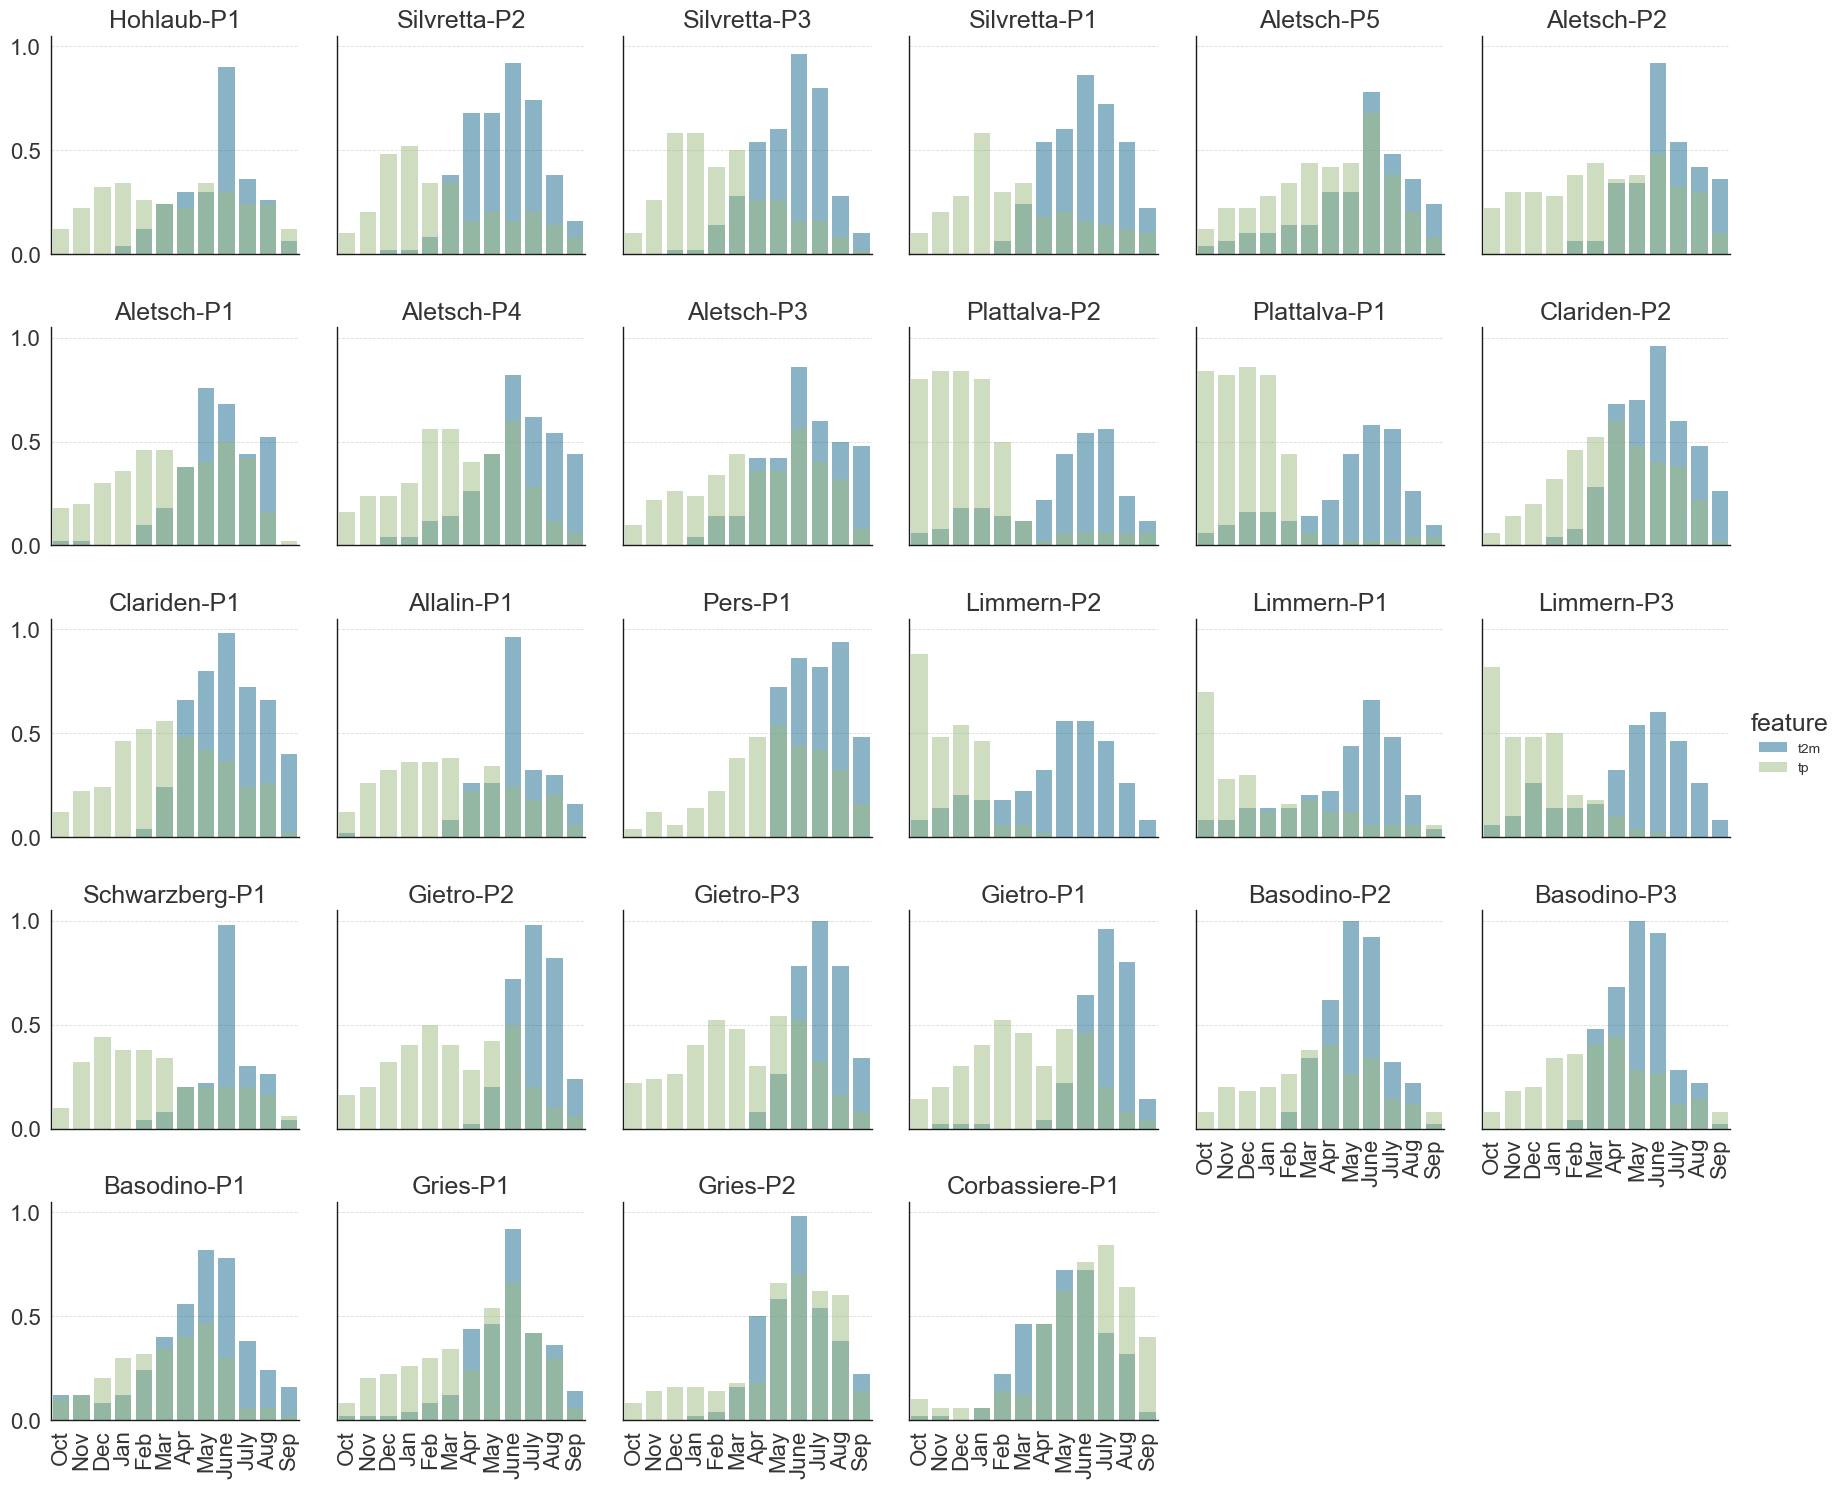

In [16]:
dfWeights_50best['stakes_new'] = dfWeights_50best['stakes'].apply(lambda x: rename_stakes[x]) 
dfWeights_50best['freq_var'] = dfWeights_50best['weight'] / 50
g = sns.FacetGrid(
    dfWeights_50best,
    col="stakes_new",
    col_wrap=6,
    hue="feature",
)
g.map(sns.barplot,
      "month",
      "freq_var",
      orient='v',
      order=INVERSE_MONTH_POS.keys(),
      alpha=0.5)
for col_val, ax in g.axes_dict.items():
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(axis="x", rotation=90)
    ax.set_title(col_val)
g.add_legend()

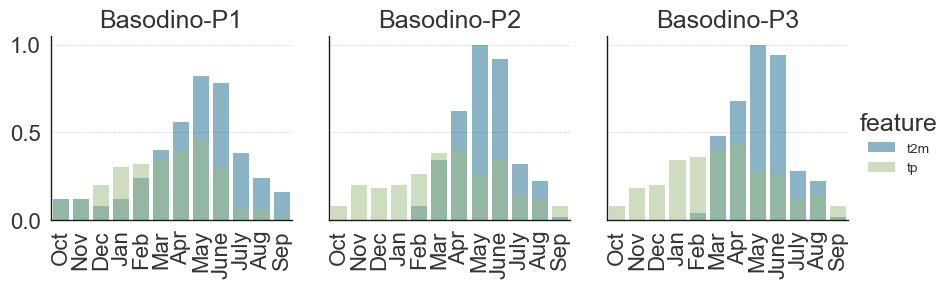

In [17]:
dfWeights_50best['stakes_new'] = dfWeights_50best['stakes'].apply(lambda x: rename_stakes[x]) 
dfWeights_50best['freq_var'] = dfWeights_50best['weight'] / 50
dfWeights_50best_subset = dfWeights_50best[dfWeights_50best.stakes_new.apply(lambda x: 'Basodino' in x)].sort_values(by = 'stakes_new')
g = sns.FacetGrid(
    dfWeights_50best_subset,
    col="stakes_new",
    col_wrap=3,
    hue="feature",
)
g.map(sns.barplot,
      "month",
      "freq_var",
      orient='v',
      order=INVERSE_MONTH_POS.keys(),
      alpha=0.5)
for col_val, ax in g.axes_dict.items():
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(axis="x", rotation=90)
    ax.set_title(col_val)
g.add_legend()

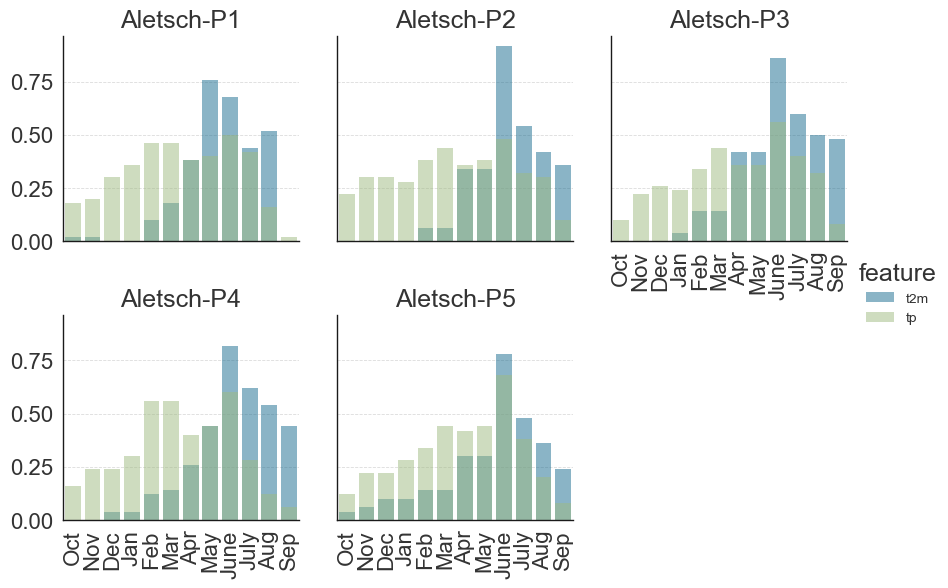

In [18]:
dfWeights_50best['stakes_new'] = dfWeights_50best['stakes'].apply(lambda x: rename_stakes[x]) 
dfWeights_50best['freq_var'] = dfWeights_50best['weight'] / 50
dfWeights_50best_subset = dfWeights_50best[dfWeights_50best.stakes_new.apply(lambda x: 'Aletsch' in x)].sort_values(by = 'stakes_new')
g = sns.FacetGrid(
    dfWeights_50best_subset,
    col="stakes_new",
    col_wrap=3,
    hue="feature",
)
g.map(sns.barplot,
      "month",
      "freq_var",
      orient='v',
      order=INVERSE_MONTH_POS.keys(),
      alpha=0.5)
for col_val, ax in g.axes_dict.items():
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(axis="x", rotation=90)
    ax.set_title(col_val)
g.add_legend()

#### 1 % highest:

In [19]:
N_combinations = 3249
N_01best = math.ceil(N_combinations * 1 / 100)
print('Number of 1% best combinations:', N_01best)
feature_importdf_percbest, dfWeights_percbest = NBestCombinations(
    dfAllStakes, INVERSE_MONTH_POS, t2m_vars, tp_vars, N=N_01best, type=VAL_METRIC)
# Aggregate over all stakes:
dfWeights_Mean_perc = dfWeights_percbest.groupby(['feature', 'month'
                                                  ]).sum().reset_index()
dfWeights_Mean_perc['type'] = np.tile(f'1% ({N_01best}) best',
                                      len(dfWeights_Mean_perc))
dfWeights_Mean_perc['freq_var'] = dfWeights_Mean_perc['weight'] / (N_01best *
                                                                   30)

Number of 1% best combinations: 33


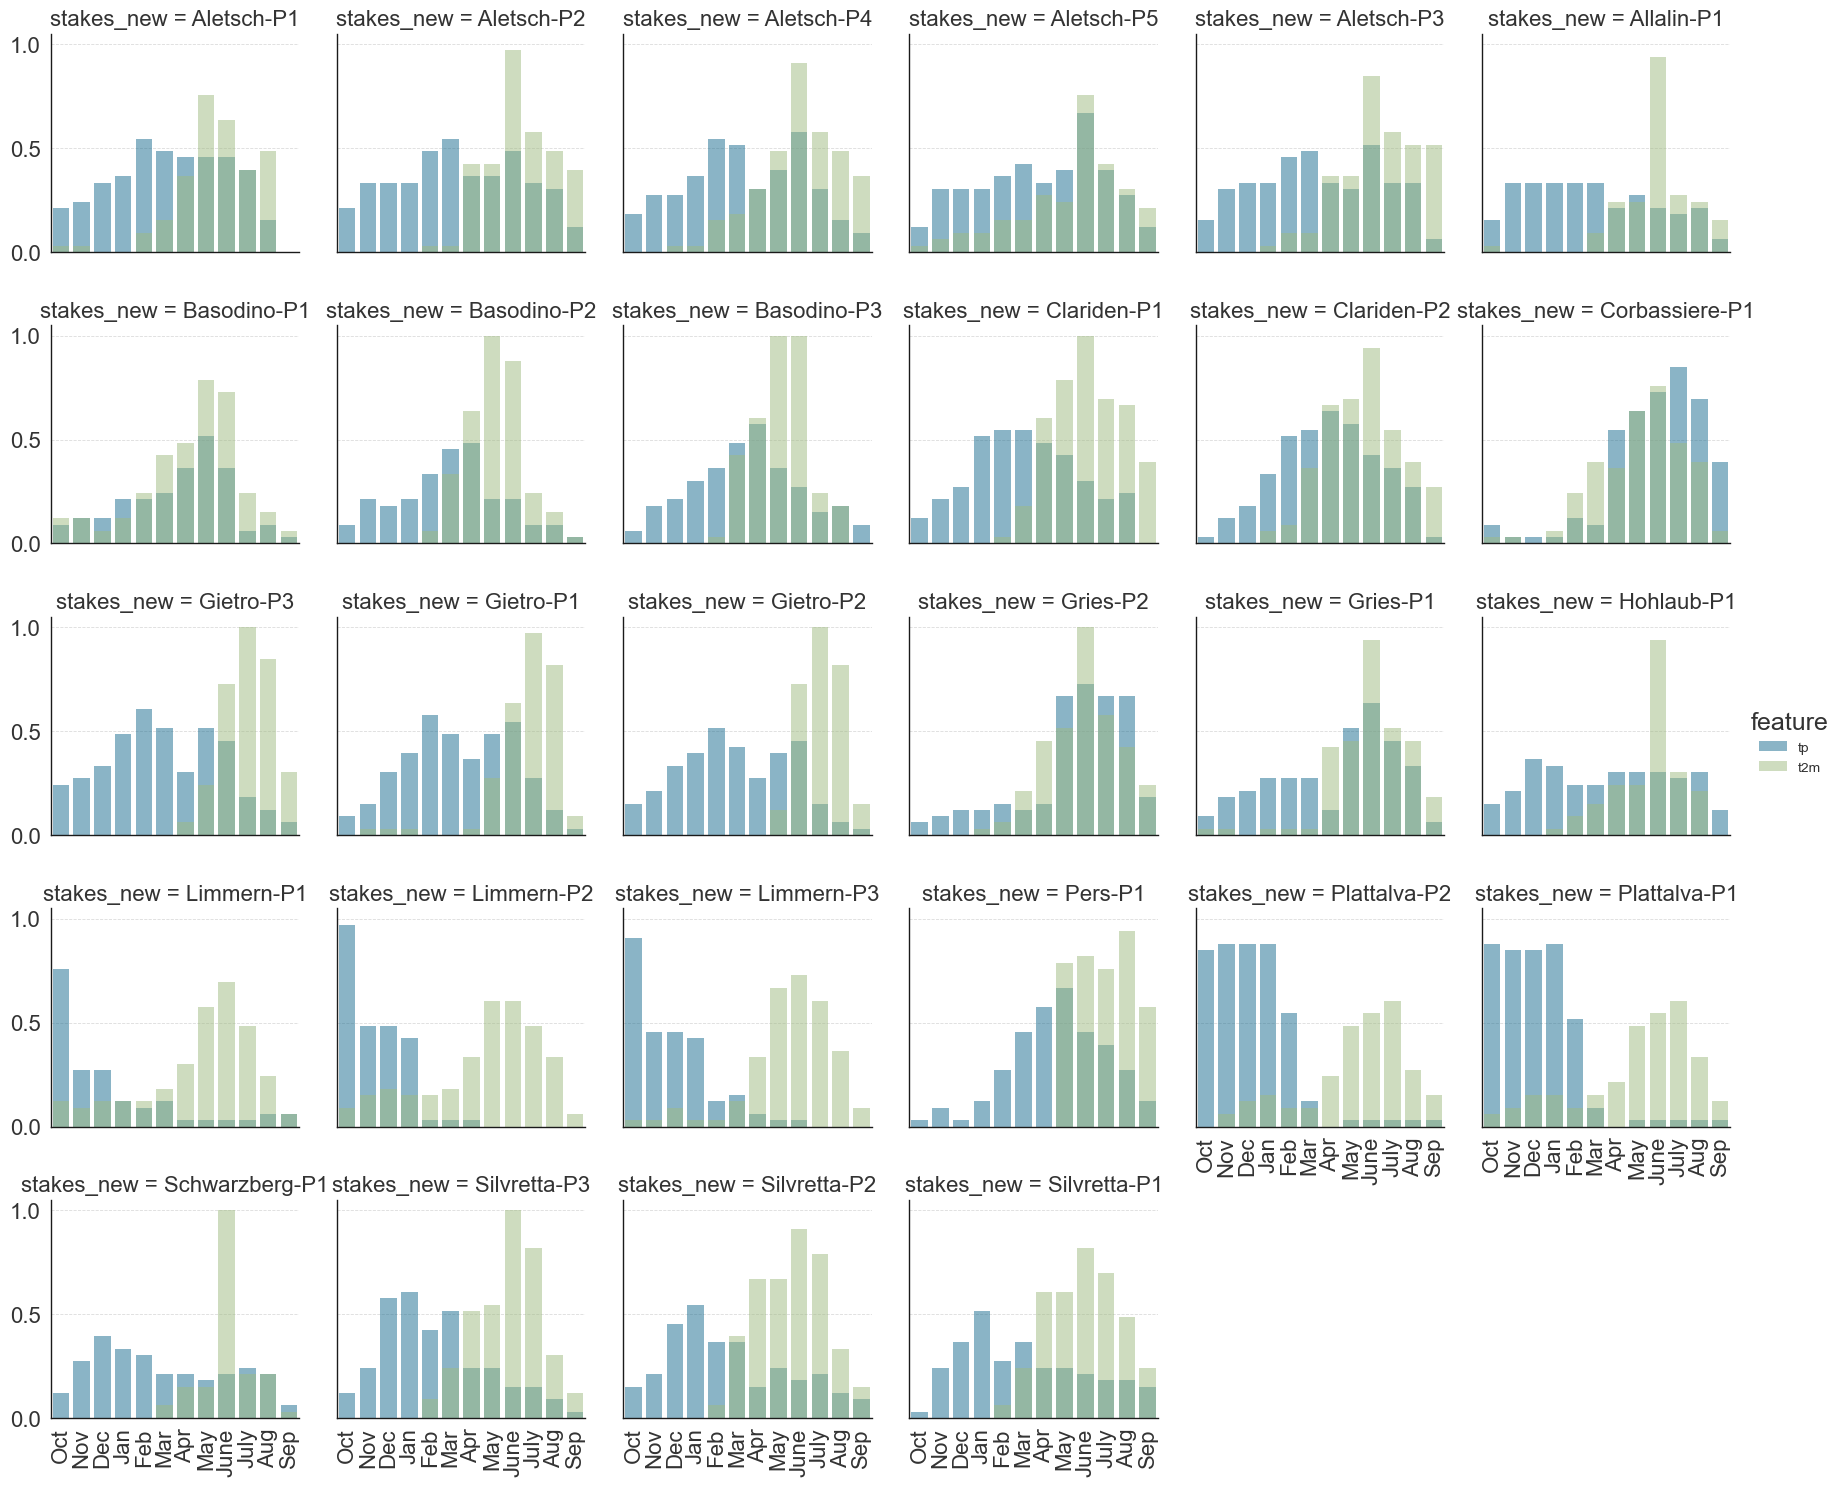

In [20]:
dfWeights_percbest['freq_var'] = dfWeights_percbest['weight'] / N_01best
dfWeights_percbest['stakes_new'] = dfWeights_percbest['stakes'].apply(lambda x: rename_stakes[x]) 
dfWeights_percbest.sort_values(by='stakes', inplace=True)
g = sns.FacetGrid(
    dfWeights_percbest,
    col="stakes_new",
    col_wrap=6,
    hue="feature",
)
g.map(sns.barplot,
      "month",
      "freq_var",
      orient='v',
      order=INVERSE_MONTH_POS.keys(),
      alpha=0.5)
for col_val, ax in g.axes_dict.items():
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(axis="x", rotation=90)
g.add_legend()

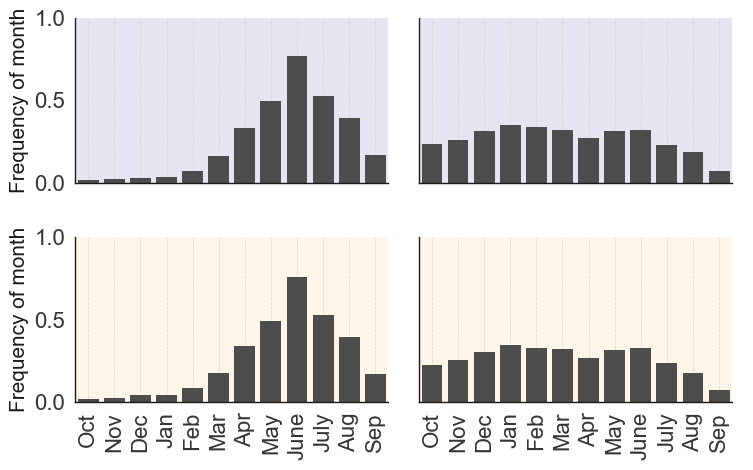

In [21]:
dfWeights_all = pd.concat([dfWeights_Mean_perc, dfWeights_Mean_50best], axis=0)
g = sns.FacetGrid(
    dfWeights_all,
    col="feature",
    row='type',
    height=2.5,
    aspect=1.5,
)
g.map(sns.barplot,
      "month",
      "freq_var",
      orient='v',
      order=INVERSE_MONTH_POS.keys(),
      color='#4d4d4d')
colors = ['#e7e5f1', '#fef5e9']

for col_val, ax in g.axes_dict.items():
    ax.set_ylabel('Frequency of month', fontsize = 15)
    ax.set_xlabel('')
    ax.set_ylim(top=1)
    ax.tick_params(axis="x", rotation=90)
    if col_val[0] == '1% (33) best':
        ax.set_facecolor(colors[0])
    if col_val[0] == '50 best':
        ax.set_facecolor(colors[1])
    ax.set_title('')
    ax.grid()
g.add_legend()

### Best over stakes:

In [22]:
# Take best average over all stakes:
avgAllStakes = dfAllStakes.groupby('t2m-tp-hash').mean().sort_values(
    by=VAL_METRIC)
avgAllStakes.head(2)

,test_rmse,val_rmse,train_rmse,test_mae,val_mae,train_mae
t2m-tp-hash,,,,,,
9023529977011800907,0.585810,0.676900,0.228699,0.421440,0.575783,0.139644
15022634069,0.580606,0.679753,0.239759,0.410514,0.584697,0.143936


In [23]:
avgAllStakes[VAL_METRIC].min(), avgAllStakes[VAL_METRIC].max()

(0.5757826079519968, 0.9741084018991106)

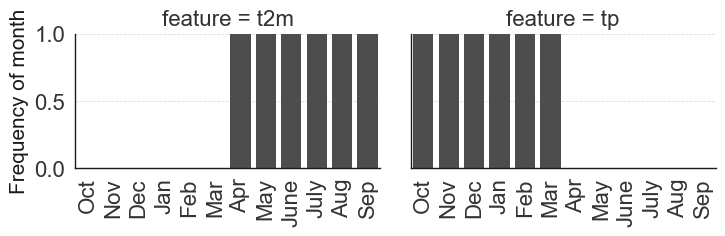

In [24]:
feature_importdf_1best, dfWeights_1best = NBestCombinations_avgStakes(
    dfAllStakes, INVERSE_MONTH_POS, t2m_vars, tp_vars, N=1, type=VAL_METRIC)
dfWeights_1best['freq_var'] = dfWeights_1best['weight'] / 1
g = sns.FacetGrid(
    dfWeights_1best,
    col="feature",
    height=2.5,
    aspect=1.5,
)
g.map(sns.barplot,
      "month",
      "freq_var",
      orient='v',
      order=INVERSE_MONTH_POS.keys(),
      color='#4d4d4d')
for col_val, ax in g.axes_dict.items():
    ax.set_ylabel('Frequency of month', fontsize = 15)
    ax.set_xlabel('')
    ax.set_ylim(top=1)
    ax.tick_params(axis="x", rotation=90)


#### Fig 5b-e: Feature importance

In [25]:
# Get weights and feature importance over 50 and 1% best combinations:
feature_importdf_50all, dfWeights_50all = NBestCombinations_avgStakes(
    dfAllStakes, INVERSE_MONTH_POS, t2m_vars, tp_vars, N=50, type=VAL_METRIC)
dfWeights_50all['freq_var'] = dfWeights_50all['weight'] / 50
dfWeights_50all['type'] = np.tile('50 best', len(dfWeights_50all))

N_01best = math.ceil(N_combinations * 1 / 100)
feature_importdf_percall, dfWeights_percall = NBestCombinations_avgStakes(
    dfAllStakes, INVERSE_MONTH_POS, t2m_vars, tp_vars, N=N_01best, type=VAL_METRIC)

dfWeights_percall['type'] = np.tile(f'1% ({N_01best}) best',
                                    len(dfWeights_percall))
dfWeights_percall['freq_var'] = dfWeights_percall['weight'] / N_01best

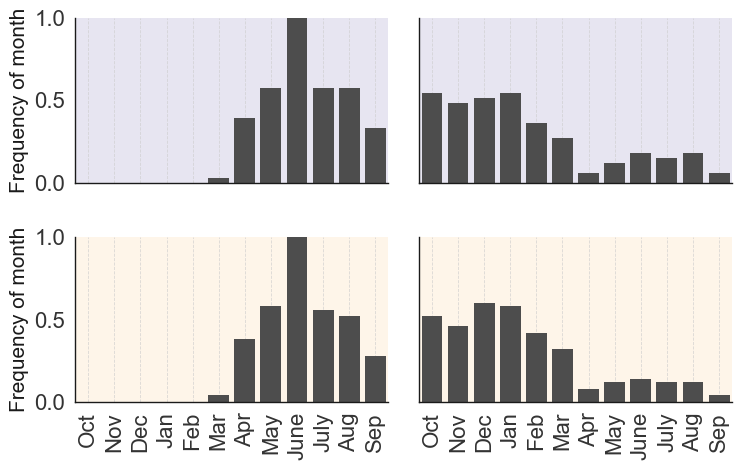

In [26]:
dfWeights_all = pd.concat([dfWeights_percall, dfWeights_50all], axis=0)
g = sns.FacetGrid(
    dfWeights_all,
    col="feature",
    row='type',
    height=2.5,
    aspect=1.5,
)
g.map(sns.barplot,
      "month",
      "freq_var",
      orient='v',
      order=INVERSE_MONTH_POS.keys(),
      color='#4d4d4d')
colors = ['#e7e5f1', '#fef5e9']

for col_val, ax in g.axes_dict.items():
    ax.set_ylabel('Frequency of month', fontsize = 15)
    ax.set_xlabel('')
    ax.set_ylim(top=1)
    ax.tick_params(axis="x", rotation=90)
    if col_val[0] == '1% (33) best':
        val_mae = feature_importdf_percall[VAL_METRIC].unique()
        ax.set_facecolor(colors[0])
    if col_val[0] == '50 best':
        val_mae = feature_importdf_50all[VAL_METRIC].unique()
        ax.set_facecolor(colors[1])
    ax.set_title('')
    ax.grid()
g.add_legend()

#### Fig 5a: distribution of feature importance

In [27]:
# What is the MAE of putting the average measured PMB for each site: 
mae_mean = []
for stake in var_xg_monthly['feat_test'].keys():
    target = np.concatenate(var_xg_monthly['feat_test'][stake]['target_test'])
    pred_mean = np.tile(np.mean(target), len(target))
    mae_mean.append(mean_absolute_error(target, pred_mean))

# average over all stakes:
mae_mean = np.mean(mae_mean)/(1000)
mae_mean

0.7004604707340956

In [28]:
perc, fifty = dfWeights_percall[VAL_METRIC].unique(), dfWeights_50all[VAL_METRIC].unique()
perc, fifty

(array([0.6266121]), array([0.63320335]))

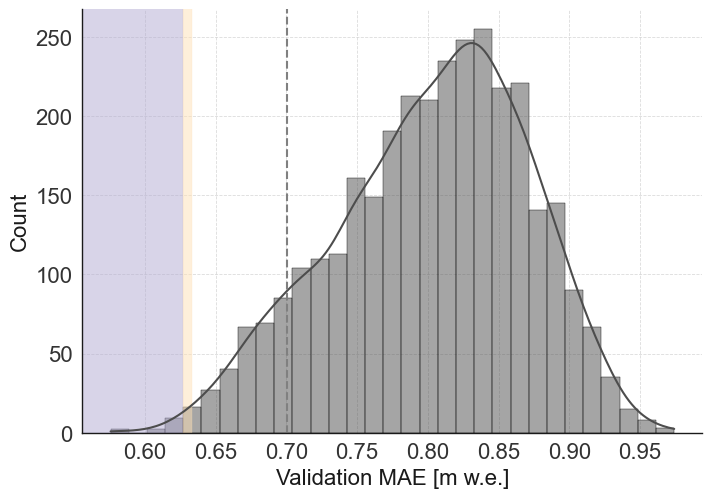

In [29]:
ax = plt.subplot(111)
perc, fifty = dfWeights_percall[VAL_METRIC].unique(), dfWeights_50all[VAL_METRIC].unique()
sns.histplot(avgAllStakes, x=VAL_METRIC, kde=True, ax=ax, color = '#4d4d4d', alpha = 0.5)
ax.set_xlabel('Validation MAE [m w.e.]')

# colors = get_cmap_hex(cm.devon, 10)
colors = ['#b2abd2', '#fee0b6']
rect1 = matplotlib.patches.Rectangle((0,0), perc[0], 300, color=colors[0], alpha = 0.5)
rect2 = matplotlib.patches.Rectangle((perc[0],0), fifty[0]-perc[0], 300, color=colors[1], alpha = 0.5)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.axvline(x=mae_mean, color='grey', linestyle='--', label='Mean measured MB')

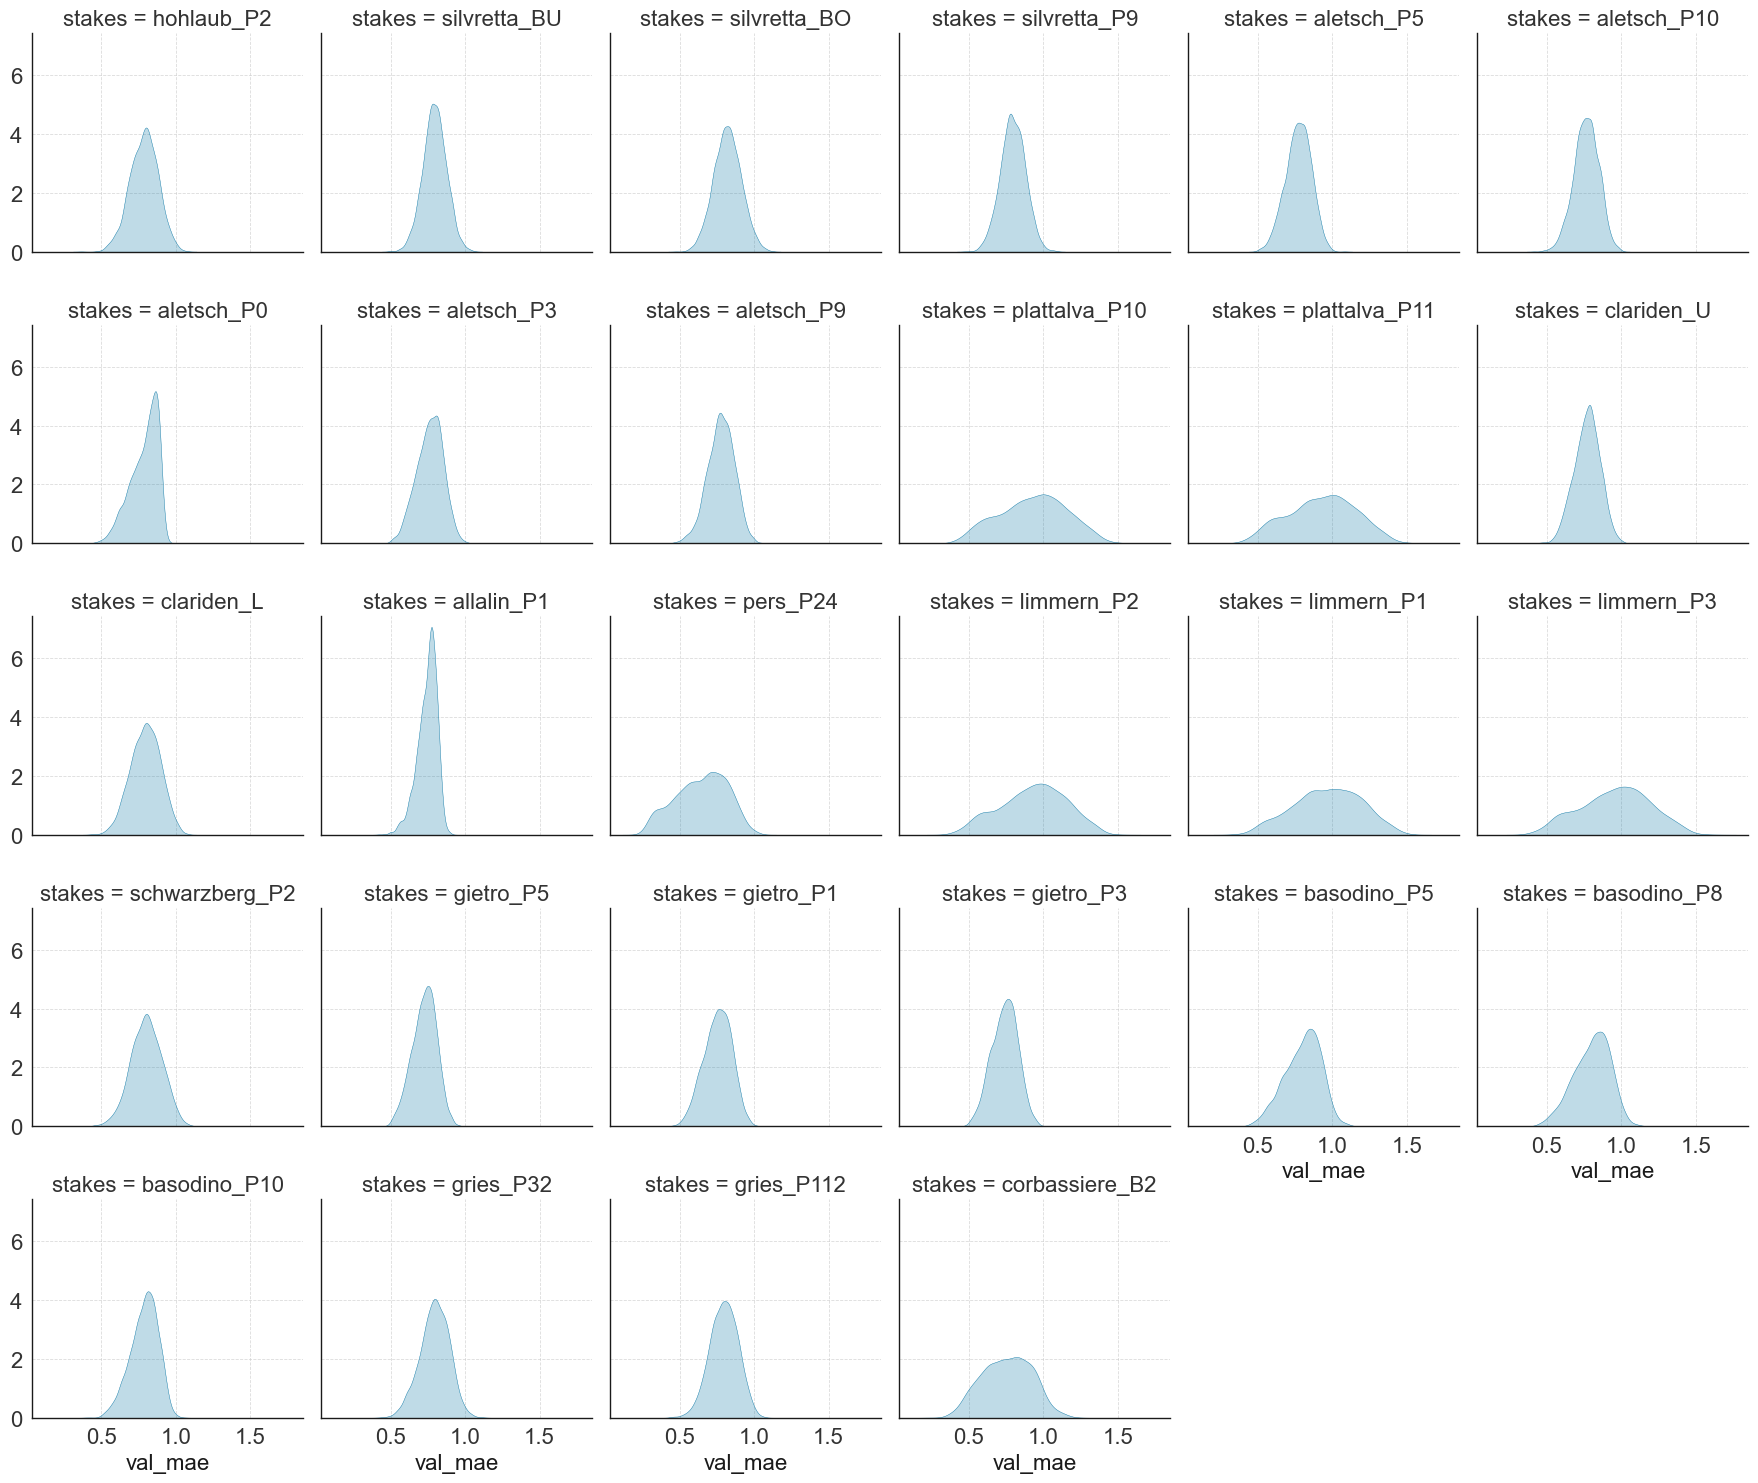

In [30]:
g = sns.FacetGrid(dfAllStakes, col="stakes", col_wrap=6)
g.map(sns.kdeplot, VAL_METRIC, palette=color_palette, fill=True
      #kde = True)
      )
for col_val, ax in g.axes_dict.items():
    ax.set_xlabel(VAL_METRIC)
    ax.set_ylabel('')

### Subset of best months:

In [31]:
best_combi = [(['t2m_Apr','t2m_May', 't2m_June', 't2m_July', 't2m_Aug', 't2m_Sep'], [
    'tp_Oct',
    'tp_Nov',
    'tp_Dec',
    'tp_Jan',
    'tp_Feb',
])]
best_months_t2m = [re.split('_', combi)[1] for combi in best_combi[0][0]]
best_months_tp = [re.split('_', combi)[1] for combi in best_combi[0][1]]

# Get all consecutive combinations of length max 6:
def consecutive_combinations(iterable, consec):
    begin = 0
    chunks = len(iterable) + 1 - consec
    return [iterable[x + begin:x + consec] for x in range(chunks)]


iterable = list(best_months_t2m)
consec_t2m = []
for i in range(1, 7):
    for el in consecutive_combinations(iterable, i):
        consec_t2m.append(['t2m_' + j for j in el])
consec_tp = ['tp_Oct', 'tp_Nov', 'tp_Dec', 'tp_Jan', 'tp_Feb']

[Text(0, 0, "['t2m_Apr', 't2m_May', 't2m_June', 't2m_July', 't2m_Aug', 't2m_Sep']"),
 Text(1, 0, "['t2m_June']"),
 Text(2, 0, "['t2m_May', 't2m_June', 't2m_July', 't2m_Aug']"),
 Text(3, 0, "['t2m_May', 't2m_June', 't2m_July', 't2m_Aug', 't2m_Sep']"),
 Text(4, 0, "['t2m_June', 't2m_July', 't2m_Aug']"),
 Text(5, 0, "['t2m_Apr', 't2m_May', 't2m_June', 't2m_July', 't2m_Aug']"),
 Text(6, 0, "['t2m_June', 't2m_July']"),
 Text(7, 0, "['t2m_July', 't2m_Aug', 't2m_Sep']"),
 Text(8, 0, "['t2m_June', 't2m_July', 't2m_Aug', 't2m_Sep']"),
 Text(9, 0, "['t2m_Apr', 't2m_May', 't2m_June']"),
 Text(10, 0, "['t2m_May', 't2m_June', 't2m_July']"),
 Text(11, 0, "['t2m_May', 't2m_June']"),
 Text(12, 0, "['t2m_Aug']"),
 Text(13, 0, "['t2m_Apr', 't2m_May', 't2m_June', 't2m_July']"),
 Text(14, 0, "['t2m_July', 't2m_Aug']"),
 Text(15, 0, "['t2m_Aug', 't2m_Sep']"),
 Text(16, 0, "['t2m_Apr', 't2m_May']"),
 Text(17, 0, "['t2m_Apr']"),
 Text(18, 0, "['t2m_July']"),
 Text(19, 0, "['t2m_May']"),
 Text(20, 0, "['t2m_S

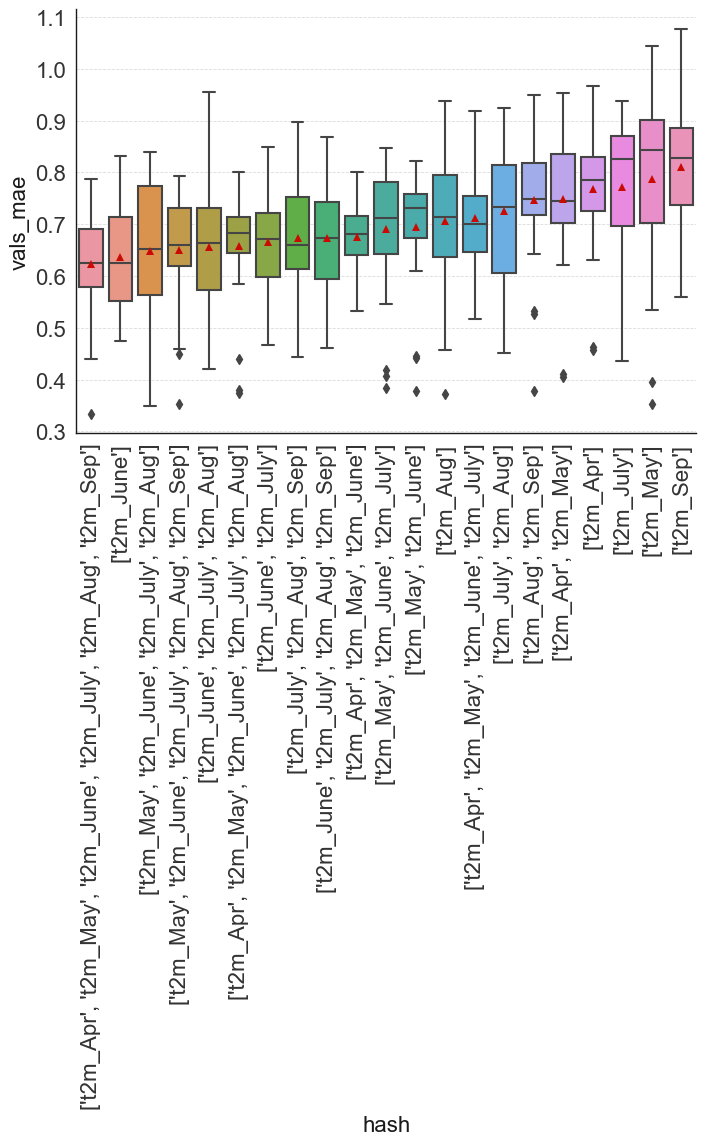

In [32]:
val_mae, vals_mae, hash = [], [], []
for t2m_combi in consec_t2m:
    t2mdf = dfAllStakes[dfAllStakes['t2m'].apply(lambda x: x == t2m_combi)]
    val_mae.append(t2mdf[t2mdf['tp'].apply(lambda x: x == consec_tp)].groupby(
        't2m-tp-hash').mean().val_mae.values[0])
    vals_mae.append(
        t2mdf[t2mdf['tp'].apply(lambda x: x == consec_tp)].val_mae.values)
    hash.append(t2mdf[t2mdf['tp'].apply(lambda x: x == consec_tp)]
                ['t2m-tp-hash'].values[0])

df = pd.DataFrame({
    'val_mae': val_mae,
    'vals_mae': vals_mae,
    't2m_combi': consec_t2m,
    'hash': hash
}).sort_values(by='val_mae')

df_expl = df[['hash', 'vals_mae']].explode('vals_mae')
ax = plt.subplot(1, 1, 1)
sns.boxplot(data=df_expl, x='hash', y='vals_mae', ax=ax, showmeans=True, order=df['hash'].values)

t2mlabels = []
for xlabel in ax.get_xticklabels():
    hash = xlabel.get_text()
    t2mlabels.append(df[df['hash'] == int(hash)].t2m_combi.values[0])

ax.set_xticklabels(t2mlabels, rotation=90)

[Text(0, 0, "['t2m_Apr', 't2m_May', 't2m_June', 't2m_July', 't2m_Aug', 't2m_Sep']"),
 Text(1, 0, "['t2m_June', 't2m_July', 't2m_Aug']"),
 Text(2, 0, "['t2m_May', 't2m_June', 't2m_July', 't2m_Aug', 't2m_Sep']"),
 Text(3, 0, "['t2m_June', 't2m_July', 't2m_Aug', 't2m_Sep']"),
 Text(4, 0, "['t2m_May', 't2m_June', 't2m_July', 't2m_Aug']"),
 Text(5, 0, "['t2m_Apr', 't2m_May', 't2m_June', 't2m_July', 't2m_Aug']"),
 Text(6, 0, "['t2m_June']"),
 Text(7, 0, "['t2m_July', 't2m_Aug', 't2m_Sep']"),
 Text(8, 0, "['t2m_June', 't2m_July']"),
 Text(9, 0, "['t2m_Apr', 't2m_May', 't2m_June']"),
 Text(10, 0, "['t2m_May', 't2m_June', 't2m_July']"),
 Text(11, 0, "['t2m_Aug']"),
 Text(12, 0, "['t2m_Apr', 't2m_May', 't2m_June', 't2m_July']"),
 Text(13, 0, "['t2m_May', 't2m_June']"),
 Text(14, 0, "['t2m_July', 't2m_Aug']"),
 Text(15, 0, "['t2m_July']"),
 Text(16, 0, "['t2m_Apr', 't2m_May']"),
 Text(17, 0, "['t2m_Aug', 't2m_Sep']"),
 Text(18, 0, "['t2m_May']"),
 Text(19, 0, "['t2m_Apr']"),
 Text(20, 0, "['t2m_S

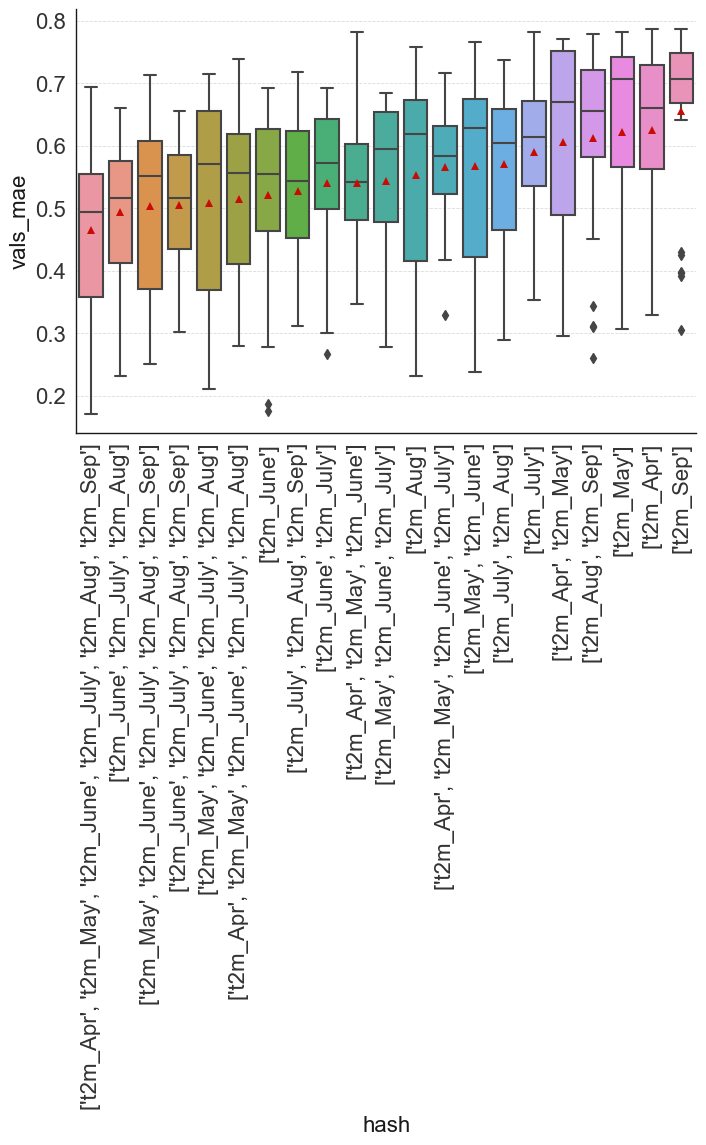

In [33]:
test_mae, vals_mae, hash = [], [], []
for t2m_combi in consec_t2m:
    t2mdf = dfAllStakes[dfAllStakes['t2m'].apply(lambda x: x == t2m_combi)]
    test_mae.append(t2mdf[t2mdf['tp'].apply(lambda x: x == consec_tp)].groupby(
        't2m-tp-hash').mean().test_mae.values[0])
    vals_mae.append(
        t2mdf[t2mdf['tp'].apply(lambda x: x == consec_tp)].test_mae.values)
    hash.append(t2mdf[t2mdf['tp'].apply(lambda x: x == consec_tp)]
                ['t2m-tp-hash'].values[0])

df = pd.DataFrame({
    'test_mae': test_mae,
    'vals_mae': vals_mae,
    't2m_combi': consec_t2m,
    'hash': hash
}).sort_values(by='test_mae')

df_expl = df[['hash', 'vals_mae']].explode('vals_mae')
ax = plt.subplot(1, 1, 1)
sns.boxplot(data=df_expl, x='hash', y='vals_mae', ax=ax, showmeans=True,order=df['hash'].values)

t2mlabels = []
for xlabel in ax.get_xticklabels():
    hash = xlabel.get_text()
    t2mlabels.append(df[df['hash'] == int(hash)].t2m_combi.values[0])

ax.set_xticklabels(t2mlabels, rotation=90)

## Train miniML-MB:

In [34]:
# Get hyper parameters for training all combinations
var_xg_monthly, metrics_monthly = assembleXGStakes(
    path_save_xgboost_stakes +
    f'{FOLD}/{INPUT_TYPE}/monthly/t2m_tp/match_annual/', glStakes_20years_all, rename_stakes, rename = False)
hp_lr = metrics_monthly['hp_lr']
hp_ne = metrics_monthly['hp_ne']
hp_md = metrics_monthly['hp_md']

hp_lr, hp_ne, hp_md

({'basodino_P5': 0.08,
  'basodino_P8': 0.074,
  'basodino_P10': 0.05,
  'gries_P32': 0.136,
  'gries_P112': 0.13,
  'schwarzberg_P2': 0.136,
  'aletsch_P5': 0.11000000000000001,
  'aletsch_P0': 0.016,
  'aletsch_P9': 0.126,
  'aletsch_P10': 0.10800000000000001,
  'aletsch_P3': 0.11000000000000001,
  'limmern_P2': 0.07399999999999998,
  'limmern_P1': 0.11000000000000001,
  'limmern_P3': 0.11000000000000001,
  'clariden_U': 0.10799999999999998,
  'clariden_L': 0.12600000000000003,
  'allalin_P1': 0.057999999999999996,
  'silvretta_P9': 0.096,
  'silvretta_BO': 0.15,
  'silvretta_BU': 0.12000000000000002,
  'hohlaub_P2': 0.11599999999999999,
  'pers_P24': 0.08,
  'corbassiere_B2': 0.11199999999999999,
  'plattalva_P10': 0.08,
  'plattalva_P11': 0.082,
  'gietro_P1': 0.118,
  'gietro_P3': 0.09200000000000001,
  'gietro_P5': 0.084},
 {'basodino_P5': 176.0,
  'basodino_P8': 194.0,
  'basodino_P10': 149.0,
  'gries_P32': 149.0,
  'gries_P112': 140.0,
  'schwarzberg_P2': 179.0,
  'aletsch_P5'

#### Normal miniML-MB

In [35]:
best_combi = [(['t2m_May', 't2m_June', 't2m_July', 't2m_Aug'], [
    'tp_Oct',
    'tp_Nov',
    'tp_Dec',
    'tp_Jan',
    'tp_Feb',
])]

best_months_t2m = [re.split('_', combi)[1] for combi in best_combi[0][0]]
best_months_tp = [re.split('_', combi)[1] for combi in best_combi[0][1]]

weights_t2m = np.ones(len(best_months_t2m))
weights_tp = np.ones(len(best_months_tp))

# Run XGBoost with best combinations of t2m variables
RUN = True
if RUN:
    runXGBoost_one_varcomb(
        best_combi,
        hp_lr,
        hp_ne,
        hp_md,
        glStakes_20years,
        param_grid,  # grid for HP search
        weights_t2m,
        weights_tp,
        mb_match='annual',
        input_type=INPUT_TYPE,
        log=False,
        empty_folder=True,
        grid_search=False,
        input_vars={
            "t2m": "temperature",
            "tp": "precipitation"
        })

Creating path: ../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/best_combi/grid_search_False/t2m_tp/5/
Matching annual MB:
------------------


glaciers:   0%|          | 0/13 [00:00<?, ?it/s]

1991 2023
1991 2023
1991 2023
1961 2023
1961 2023
1955 2023
1920 2023
1995 2023
1920 2023
1920 2023
1920 2023
1948 1984
1948 1984
1948 1984
1914 2023
1914 2023
1955 2023
1914 2023
1914 2023
1914 2023
1955 2023
2001 2023
1996 2023
1948 1984
1948 1984
1966 2023
1966 2023
1966 2023


#### miniML-MB with PDD instead of T:

In [37]:
best_combi = [(['t2m_May', 't2m_June', 't2m_July', 't2m_Aug'], [
    'tp_Oct',
    'tp_Nov',
    'tp_Dec',
    'tp_Jan',
    'tp_Feb',
])]

best_months_t2m = [re.split('_', combi)[1] for combi in best_combi[0][0]]
best_months_tp = [re.split('_', combi)[1] for combi in best_combi[0][1]]

weights_t2m = np.ones(len(best_months_t2m))
weights_tp = np.ones(len(best_months_tp))

# Run XGBoost with PDD instead of t2m
RUN = False
if RUN:
    runXGBoost_one_varcomb(
        best_combi,
        hp_lr,
        hp_ne,
        hp_md,
        glStakes_20years,
        param_grid,  # grid for HP search
        weights_t2m,
        weights_tp,
        mb_match='annual',
        input_type=INPUT_TYPE,
        log=False,
        empty_folder=True,
        grid_search=False,
        input_vars={
            "pdd": "temperature",
            "tp": "precipitation"
        })

#### miniML-MB with weighted T and P:

In [38]:
best_combi = [(['t2m_May', 't2m_June', 't2m_July', 't2m_Aug'], [
    'tp_Oct',
    'tp_Nov',
    'tp_Dec',
    'tp_Jan',
    'tp_Feb',
])]

best_months_t2m = [re.split('_', combi)[1] for combi in best_combi[0][0]]
best_months_tp = [re.split('_', combi)[1] for combi in best_combi[0][1]]

weights_all_t2m = dfWeights_all[(dfWeights_all.feature == 't2m')&(dfWeights_all.type == '50 best')]
weights_all_tp = dfWeights_all[(dfWeights_all.feature == 'tp')&(dfWeights_all.type == '50 best')]

weights_t2m = weights_all_t2m[weights_all_t2m.month.apply(lambda x: x in best_months_t2m)].freq_var.values
weights_tp = weights_all_tp[weights_all_tp.month.apply(lambda x: x in best_months_tp)].freq_var.values

weights_t2m, weights_tp

(array([0.58, 1.  , 0.56, 0.52]), array([0.52, 0.46, 0.6 , 0.58, 0.42]))

In [39]:
# Run XGBoost with best combinations of t2m variables
RUN = False
if RUN:
    runXGBoost_one_varcomb(
        best_combi,
        hp_lr,
        hp_ne,
        hp_md,
        glStakes_20years,
        param_grid,  # grid for HP search
        weights_t2m,
        weights_tp,
        mb_match='annual',
        input_type=INPUT_TYPE,
        log=False,
        empty_folder=True,
        grid_search=False,
        input_vars={
            "t2m": "temperature",
            "tp": "precipitation"
        })

## Clustering on stakes' combinations:

In [40]:
color_palette = sns.color_palette("husl", len(MONTH_VAL.keys()))
palette = {}
for ind in MONTH_VAL.keys():
    palette[MONTH_VAL[ind]] = color_palette[ind - 1]

feature_list = [
    't2m_Oct', 't2m_Nov', 't2m_Dec', 't2m_Jan', 't2m_Feb', 't2m_Mar',
    't2m_Apr', 't2m_May', 't2m_June', 't2m_July', 't2m_Aug', 't2m_Sep',
    'tp_Oct', 'tp_Nov', 'tp_Dec', 'tp_Jan', 'tp_Feb', 'tp_Mar', 'tp_Apr',
    'tp_May', 'tp_June', 'tp_July', 'tp_Aug', 'tp_Sep'
]

In [41]:
# dfWeights = dfWeights_percbest

dfWeights = dfWeights_50best

# Add a month key for clustering
dfWeights['month_key'] = [
    INVERSE_MONTH_POS[dfWeights.month.iloc[i]] for i in range(len(dfWeights))
]
dfWeights.sort_values(by=[
    'stakes',
    'feature',
    'month_key',
], inplace=True)

# Transform dataframe for clustering so that there is one column per variable:
df_cluster = pd.DataFrame()
for stake in dfWeights.stakes.unique():
    df_cluster = pd.concat([
        df_cluster,
        pd.DataFrame(dfWeights[dfWeights.stakes == stake].freq_var.values)
    ],
                           axis=1)
df_cluster = pd.DataFrame()
for stake in dfWeights.stakes.unique():
    df_cluster = pd.concat([
        df_cluster,
        pd.DataFrame(dfWeights[dfWeights.stakes == stake].freq_var.values)
    ],
                           axis=1)
df_cluster = df_cluster.transpose()
df_cluster.columns = feature_list
df_cluster['stake'] = dfWeights.stakes.unique()
df_cluster.set_index('stake', inplace=True)
df_cluster.head(2)

,t2m_Oct,t2m_Nov,t2m_Dec,t2m_Jan,t2m_Feb,t2m_Mar,t2m_Apr,t2m_May,t2m_June,t2m_July,...,tp_Dec,tp_Jan,tp_Feb,tp_Mar,tp_Apr,tp_May,tp_June,tp_July,tp_Aug,tp_Sep
stake,,,,,,,,,,,,,,,,,,,,,
aletsch_P0,0.02,0.02,0.0,0.0,0.10,0.18,0.38,0.76,0.68,0.44,...,0.3,0.36,0.46,0.46,0.38,0.40,0.50,0.42,0.16,0.02
aletsch_P10,0.00,0.00,0.0,0.0,0.06,0.06,0.34,0.34,0.92,0.54,...,0.3,0.28,0.38,0.44,0.36,0.38,0.48,0.32,0.30,0.10


### Clustering on TP & T2M:

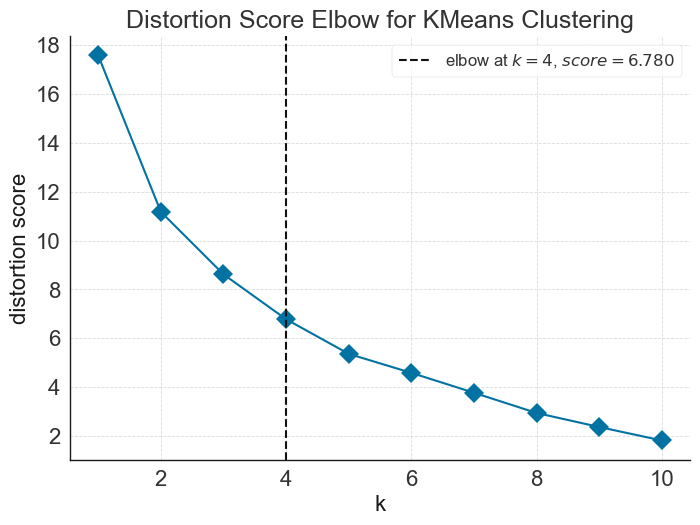

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [49]:
# K-means++:
# Here cluster on total temperature only
X = df_cluster.values
scl = StandardScaler()
Xnorm = scl.fit_transform(X)
# Kmeans params
kmeans_params = {
    'init': 'k-means++',
    'max_iter': 300,
    'n_init': 10,
    'random_state': SEED
}
# Elbow method:
model = KMeans(**kmeans_params)
visualizer = KElbowVisualizer(model, k=(1, 11), timings=False)
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

#### Fig 11: Clustering of T & P

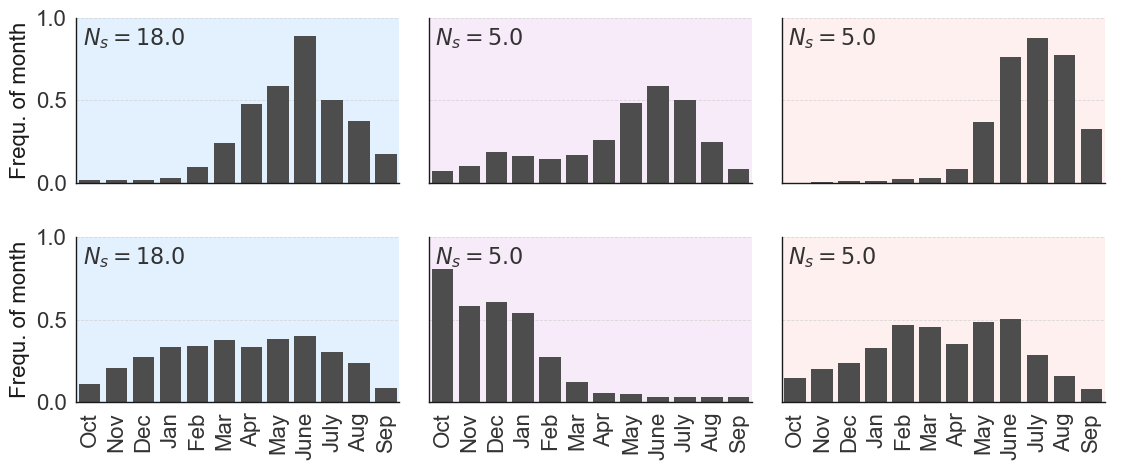

In [50]:
# Applying K-Means to the dataset:
N_c = 3  # number of clusters
kmeans = KMeans(n_clusters=N_c, **kmeans_params)
y_kmeans = kmeans.fit_predict(X)
DF_cluster = df_cluster.copy()
DF_cluster['cluster'] = y_kmeans

# Assemble in a dataframe where columns are months (for plotting):
# T2m:
df_cluster_t2m = DF_cluster[[
    't2m_Oct', 't2m_Nov', 't2m_Dec', 't2m_Jan', 't2m_Feb', 't2m_Mar',
    't2m_Apr', 't2m_May', 't2m_June', 't2m_July', 't2m_Aug', 't2m_Sep',
    'cluster'
]]
df_cluster_t2m.rename(columns={
    't2m_Oct': 0,
    't2m_Nov': 1,
    't2m_Dec': 2,
    't2m_Jan': 3,
    't2m_Feb': 4,
    't2m_Mar': 5,
    't2m_Apr': 6,
    't2m_May': 7,
    't2m_June': 8,
    't2m_July': 9,
    't2m_Aug': 10,
    't2m_Sep': 11
},inplace=True)
df_cluster_t2m['feature'] = np.tile('t2m', len(df_cluster_t2m))

# TP:
df_cluster_tp = DF_cluster[[
    'tp_Oct', 'tp_Nov', 'tp_Dec', 'tp_Jan', 'tp_Feb', 'tp_Mar', 'tp_Apr',
    'tp_May', 'tp_June', 'tp_July', 'tp_Aug', 'tp_Sep', 'cluster'
]]
df_cluster_tp.rename(columns={
    'tp_Oct': 0,
    'tp_Nov': 1,
    'tp_Dec': 2,
    'tp_Jan': 3,
    'tp_Feb': 4,
    'tp_Mar': 5,
    'tp_Apr': 6,
    'tp_May': 7,
    'tp_June': 8,
    'tp_July': 9,
    'tp_Aug': 10,
    'tp_Sep': 11
},inplace=True)
df_cluster_tp['feature'] = np.tile('tp', len(df_cluster_tp))
df_clusters_per_feat = pd.concat([df_cluster_t2m, df_cluster_tp], axis=0)

PlotFeatClusters(df_clusters_per_feat)

Stakes of cluster 0:
 []
Stakes of cluster 1:
 ['aletsch_P0' 'aletsch_P10' 'aletsch_P5' 'aletsch_P9' 'allalin_P1'
 'basodino_P10' 'basodino_P5' 'basodino_P8' 'clariden_L' 'clariden_U'
 'corbassiere_B2' 'gries_P112' 'gries_P32' 'hohlaub_P2' 'schwarzberg_P2'
 'silvretta_BO' 'silvretta_BU' 'silvretta_P9']
Stakes of cluster 2:
 ['limmern_P1' 'limmern_P2' 'limmern_P3' 'plattalva_P10' 'plattalva_P11']


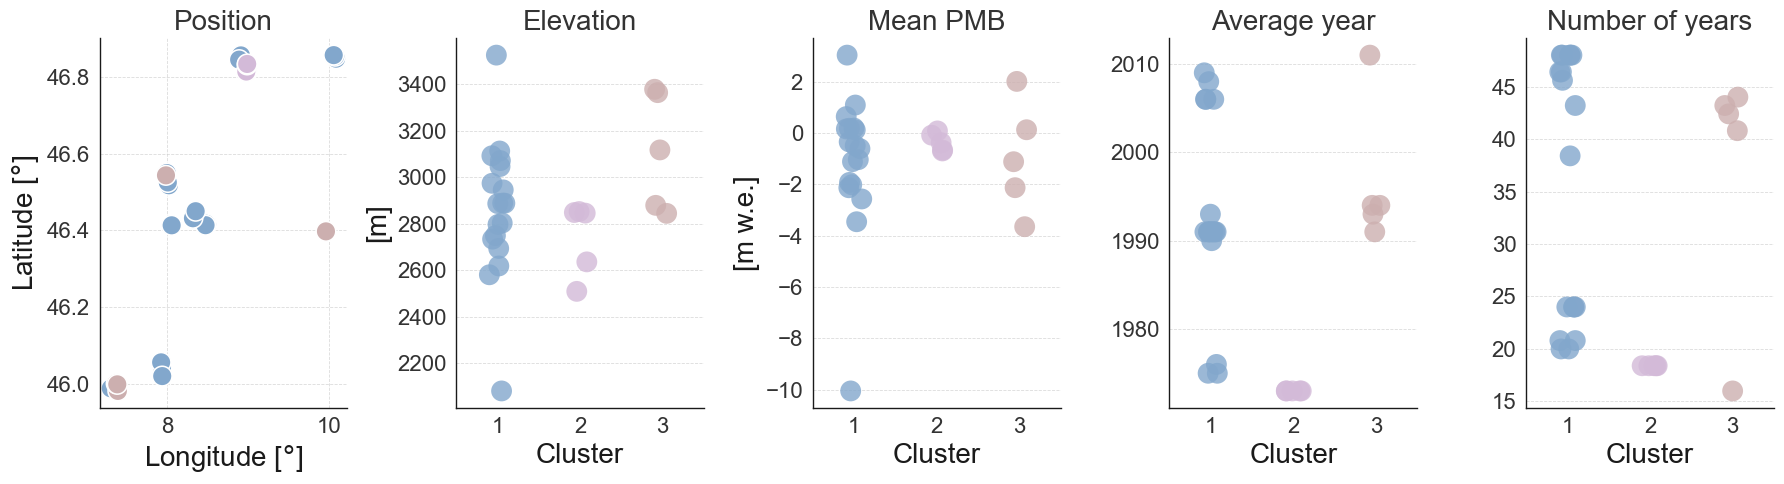

In [51]:
# Get attributes of clusters:
cl_elev, clnb, cl_lat, cl_lon, stakes, glaciers, glshort = [], [], [], [], [], [], []
training_mb, training_y, len_training = [], [], []
for cl_nb in DF_cluster['cluster'].unique():
    cl_stakes = DF_cluster[DF_cluster['cluster'] == cl_nb].index
    for stake in cl_stakes:
        f_stake = read_stake_csv(path_glacattr, f'{stake}_mb.csv')
        cl_elev.append(np.mean(f_stake.height))
        cl_lat.append(np.mean(f_stake.lat))
        cl_lon.append(np.mean(f_stake.lon))
        len_training.append(
            len(var_xg_monthly['feat_train'][stake]['target']) / NUM_FOLDS)
        # mean training mb
        training_mb.append(
            np.mean(var_xg_monthly['feat_train'][stake]['target']))
        training_y.append(
            int(np.mean(var_xg_monthly['feat_train'][stake]['time'])))
        clnb.append(cl_nb+1)
        stakes.append(stake)
        glaciers.append(re.split('_', stake)[0])
        glshort.append(GL_SHORT[re.split('_', stake)[0]] + '_' +
                       re.split('_', stake)[1])

df_info = pd.DataFrame({
    'elevation': cl_elev,
    'lon': cl_lon,
    'lat': cl_lat,
    'training_mb': training_mb,
    'training_time': training_y,
    'training_length': len_training,
    'cluster': clnb,
    'stakes': stakes,
    'glaciers': glaciers,
    'glshort': glshort
})
df_info["cluster"] = df_info["cluster"].astype("category")

mean_df = pd.DataFrame({
    'cluster':
    range(1, N_c+1),
    'mean_el':
    df_info.groupby('cluster').mean().elevation,
    'mean_mb':
    df_info.groupby('cluster').mean()['training_mb']
})
for clusterNb in range(df_info['cluster'].nunique()):
    stakes_c0 = df_info[df_info['cluster'] == clusterNb].stakes.values
    print(f'Stakes of cluster {clusterNb}:\n {stakes_c0}')
plotClusterStats(df_info, mean_df)

### Clustering on TP:

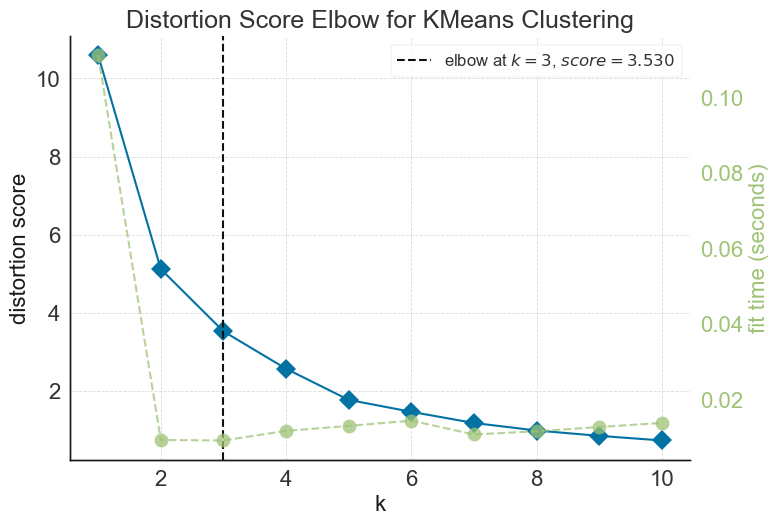

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [42]:
# K-means++:
# Here cluster on total precipitation only
X = df_cluster[[
    'tp_Oct', 'tp_Nov', 'tp_Dec', 'tp_Jan', 'tp_Feb', 'tp_Mar', 'tp_Apr',
    'tp_May', 'tp_June', 'tp_July', 'tp_Aug', 'tp_Sep'
]].values
scl = StandardScaler()
Xnorm = scl.fit_transform(X)
# Kmeans params
kmeans_params = {
    'init': 'k-means++',
    'max_iter': 300,
    'n_init': 10,
    'random_state': SEED
}
# Elbow method:
model = KMeans(**kmeans_params)
visualizer = KElbowVisualizer(model, k=(1, 11))
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

In [43]:
# Applying K-Means to the dataset:
N_c = 3  # number of clusters
kmeans = KMeans(n_clusters=N_c, **kmeans_params)
y_kmeans = kmeans.fit_predict(X)
DF_cluster = df_cluster.copy()
DF_cluster['cluster'] = y_kmeans

# Assemble in a dataframe where columns are months (for plotting):
# T2m:
df_cluster_t2m = DF_cluster[[
    't2m_Oct', 't2m_Nov', 't2m_Dec', 't2m_Jan', 't2m_Feb', 't2m_Mar',
    't2m_Apr', 't2m_May', 't2m_June', 't2m_July', 't2m_Aug', 't2m_Sep',
    'cluster'
]]
df_cluster_t2m.rename(columns={
    't2m_Oct': 0,
    't2m_Nov': 1,
    't2m_Dec': 2,
    't2m_Jan': 3,
    't2m_Feb': 4,
    't2m_Mar': 5,
    't2m_Apr': 6,
    't2m_May': 7,
    't2m_June': 8,
    't2m_July': 9,
    't2m_Aug': 10,
    't2m_Sep': 11
},inplace=True)
df_cluster_t2m['feature'] = np.tile('t2m', len(df_cluster_t2m))

# TP:
df_cluster_tp = DF_cluster[[
    'tp_Oct', 'tp_Nov', 'tp_Dec', 'tp_Jan', 'tp_Feb', 'tp_Mar', 'tp_Apr',
    'tp_May', 'tp_June', 'tp_July', 'tp_Aug', 'tp_Sep', 'cluster'
]]
df_cluster_tp.rename(columns={
    'tp_Oct': 0,
    'tp_Nov': 1,
    'tp_Dec': 2,
    'tp_Jan': 3,
    'tp_Feb': 4,
    'tp_Mar': 5,
    'tp_Apr': 6,
    'tp_May': 7,
    'tp_June': 8,
    'tp_July': 9,
    'tp_Aug': 10,
    'tp_Sep': 11
},inplace=True)
df_cluster_tp['feature'] = np.tile('tp', len(df_cluster_tp))
df_clusters_per_feat = pd.concat([df_cluster_t2m, df_cluster_tp], axis=0)
df_clusters_per_feat.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,cluster,feature
stake,,,,,,,,,,,,,,
aletsch_P0,0.02,0.02,0.0,0.0,0.10,0.18,0.38,0.76,0.68,0.44,0.52,0.00,1,t2m
aletsch_P10,0.00,0.00,0.0,0.0,0.06,0.06,0.34,0.34,0.92,0.54,0.42,0.36,1,t2m


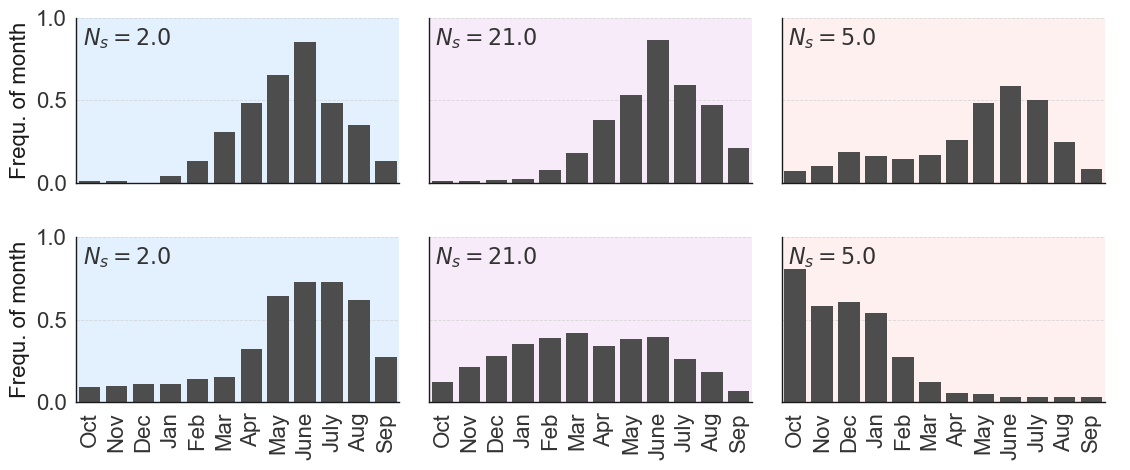

In [44]:
PlotFeatClusters(df_clusters_per_feat)

#### Attributes per cluster:

Stakes of cluster 0:
 ['corbassiere_B2' 'gries_P112']
Stakes of cluster 1:
 ['aletsch_P0' 'aletsch_P10' 'aletsch_P3' 'aletsch_P5' 'aletsch_P9'
 'allalin_P1' 'basodino_P10' 'basodino_P5' 'basodino_P8' 'clariden_L'
 'clariden_U' 'gietro_P1' 'gietro_P3' 'gietro_P5' 'gries_P32' 'hohlaub_P2'
 'pers_P24' 'schwarzberg_P2' 'silvretta_BO' 'silvretta_BU' 'silvretta_P9']
Stakes of cluster 2:
 ['limmern_P1' 'limmern_P2' 'limmern_P3' 'plattalva_P10' 'plattalva_P11']


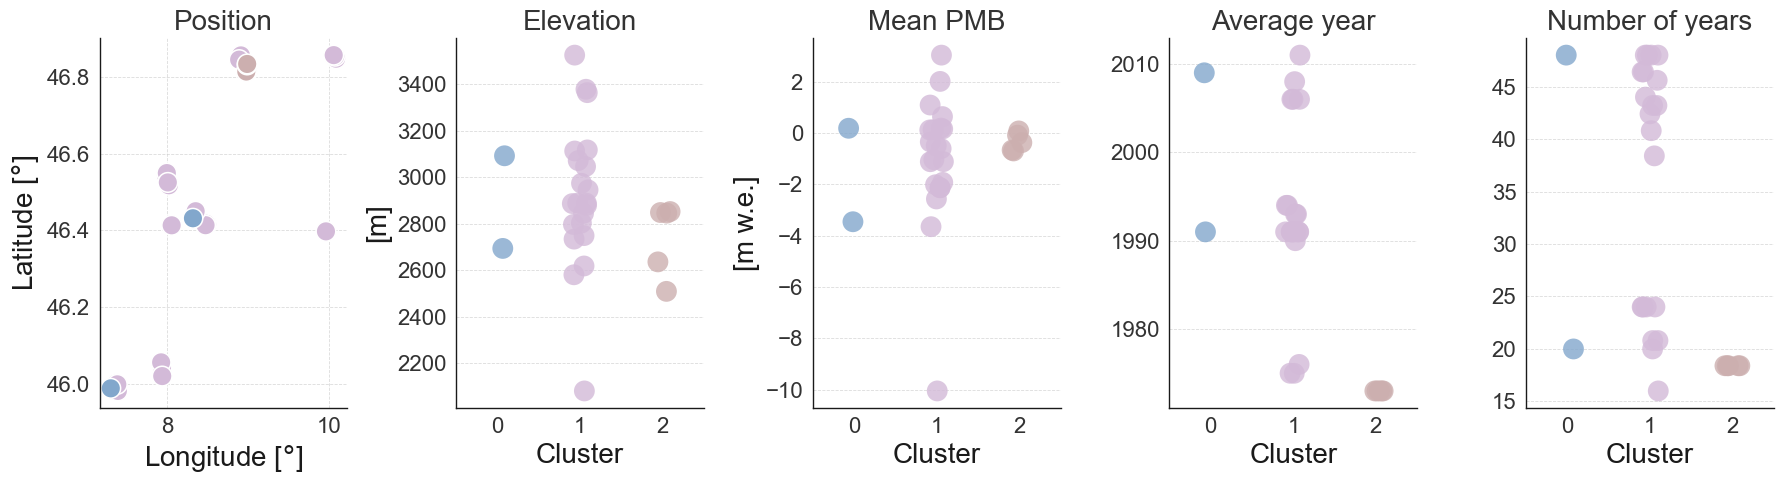

In [45]:
GL_SHORT = {'basodino': 'BAS',
 'gries': 'GRI',
 'schwarzberg': 'SCH',
 'aletsch': 'ALE',
 'limmern': 'LIM',
 'clariden': 'CLA',
 'allalin': 'ALL',
 'silvretta': 'SIL',
 'hohlaub': 'HOH',
 'pers': 'PERS',
 'corbassiere': 'COR',
 'plattalva': 'PLA',
 'gietro': 'GIE'}

# Get attributes of clusters:
cl_elev, clnb, cl_lat, cl_lon, stakes, glaciers, glshort = [], [], [], [], [], [], []
training_mb, training_y, len_training = [], [], []
for cl_nb in DF_cluster['cluster'].unique():
    cl_stakes = DF_cluster[DF_cluster['cluster'] == cl_nb].index
    for stake in cl_stakes:
        f_stake = read_stake_csv(path_glacattr, f'{stake}_mb.csv')
        cl_elev.append(np.mean(f_stake.height))
        cl_lat.append(np.mean(f_stake.lat))
        cl_lon.append(np.mean(f_stake.lon))
        len_training.append(
            len(var_xg_monthly['feat_train'][stake]['target']) / NUM_FOLDS)
        # mean training mb
        training_mb.append(
            np.mean(var_xg_monthly['feat_train'][stake]['target']))
        training_y.append(
            int(np.mean(var_xg_monthly['feat_train'][stake]['time'])))
        clnb.append(cl_nb)
        stakes.append(stake)
        glaciers.append(re.split('_', stake)[0])
        glshort.append(GL_SHORT[re.split('_', stake)[0]] + '_' +
                       re.split('_', stake)[1])

df_info = pd.DataFrame({
    'elevation': cl_elev,
    'lon': cl_lon,
    'lat': cl_lat,
    'training_mb': training_mb,
    'training_time': training_y,
    'training_length': len_training,
    'cluster': clnb,
    'stakes': stakes,
    'glaciers': glaciers,
    'glshort': glshort
})
df_info["cluster"] = df_info["cluster"].astype("category")

mean_df = pd.DataFrame({
    'cluster':
    range(0, N_c),
    'mean_el':
    df_info.groupby('cluster').mean().elevation,
    'mean_mb':
    df_info.groupby('cluster').mean()['training_mb']
})
stakes_c0 = df_info[df_info['cluster'] == 0].stakes.values
stakes_c1 = df_info[df_info['cluster'] == 1].stakes.values
stakes_c2 = df_info[df_info['cluster'] == 2].stakes.values
print(f'Stakes of cluster 0:\n {stakes_c0}')
print(f'Stakes of cluster 1:\n {stakes_c1}')
print(f'Stakes of cluster 2:\n {stakes_c2}')

plotClusterStats(df_info, mean_df)


### Clustering on T2M:

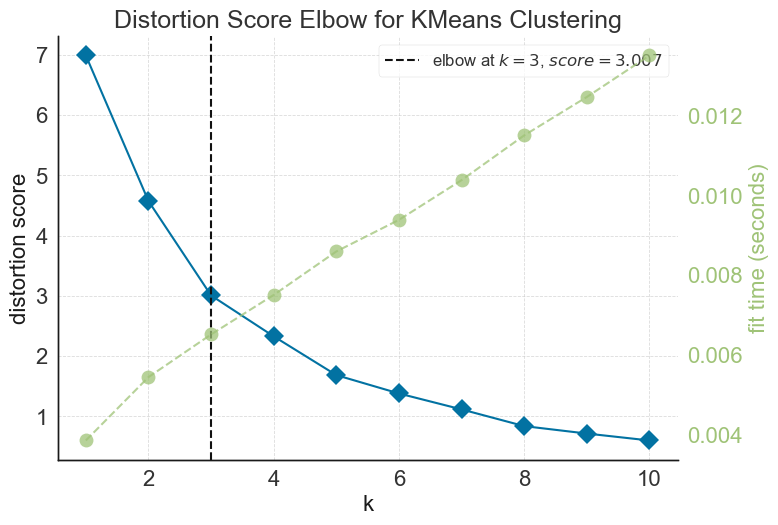

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [46]:
# K-means++:
# Here cluster on total temperature only
X = df_cluster[[
    't2m_Oct', 't2m_Nov', 't2m_Dec', 't2m_Jan', 't2m_Feb', 't2m_Mar',
    't2m_Apr', 't2m_May', 't2m_June', 't2m_July', 't2m_Aug', 't2m_Sep',
]].values
scl = StandardScaler()
Xnorm = scl.fit_transform(X)
# Kmeans params
kmeans_params = {
    'init': 'k-means++',
    'max_iter': 300,
    'n_init': 10,
    'random_state': SEED
}
# Elbow method:
model = KMeans(**kmeans_params)
visualizer = KElbowVisualizer(model, k=(1, 11))
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

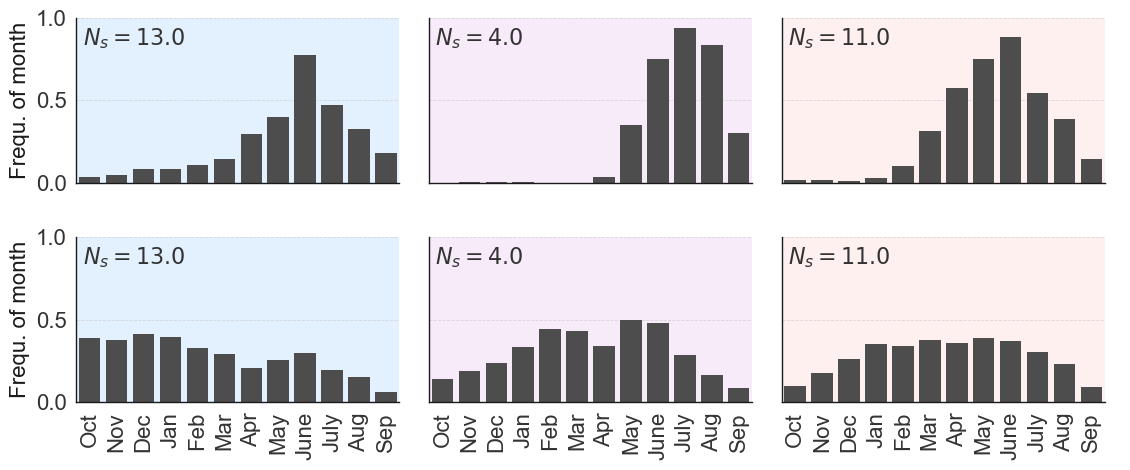

In [47]:
# Applying K-Means to the dataset:
N_c = 3  # number of clusters
kmeans = KMeans(n_clusters=N_c, **kmeans_params)
y_kmeans = kmeans.fit_predict(X)
DF_cluster = df_cluster.copy()
DF_cluster['cluster'] = y_kmeans
# Assemble in a dataframe where columns are months (for plotting):
# T2m:
df_cluster_t2m = DF_cluster[[
    't2m_Oct', 't2m_Nov', 't2m_Dec', 't2m_Jan', 't2m_Feb', 't2m_Mar',
    't2m_Apr', 't2m_May', 't2m_June', 't2m_July', 't2m_Aug', 't2m_Sep',
    'cluster'
]]
df_cluster_t2m.rename(columns={
    't2m_Oct': 0,
    't2m_Nov': 1,
    't2m_Dec': 2,
    't2m_Jan': 3,
    't2m_Feb': 4,
    't2m_Mar': 5,
    't2m_Apr': 6,
    't2m_May': 7,
    't2m_June': 8,
    't2m_July': 9,
    't2m_Aug': 10,
    't2m_Sep': 11
},inplace=True)
df_cluster_t2m['feature'] = np.tile('t2m', len(df_cluster_t2m))

# TP:
df_cluster_tp = DF_cluster[[
    'tp_Oct', 'tp_Nov', 'tp_Dec', 'tp_Jan', 'tp_Feb', 'tp_Mar', 'tp_Apr',
    'tp_May', 'tp_June', 'tp_July', 'tp_Aug', 'tp_Sep', 'cluster'
]]
df_cluster_tp.rename(columns={
    'tp_Oct': 0,
    'tp_Nov': 1,
    'tp_Dec': 2,
    'tp_Jan': 3,
    'tp_Feb': 4,
    'tp_Mar': 5,
    'tp_Apr': 6,
    'tp_May': 7,
    'tp_June': 8,
    'tp_July': 9,
    'tp_Aug': 10,
    'tp_Sep': 11
},inplace=True)
df_cluster_tp['feature'] = np.tile('tp', len(df_cluster_tp))
df_clusters_per_feat = pd.concat([df_cluster_t2m, df_cluster_tp], axis=0)
df_clusters_per_feat.head(2)

PlotFeatClusters(df_clusters_per_feat)

Stakes of cluster 0:
 ['aletsch_P10' 'aletsch_P3' 'aletsch_P5' 'aletsch_P9' 'allalin_P1'
 'gries_P32' 'hohlaub_P2' 'limmern_P1' 'limmern_P2' 'limmern_P3'
 'plattalva_P10' 'plattalva_P11' 'schwarzberg_P2']
Stakes of cluster 1:
 ['gietro_P1' 'gietro_P3' 'gietro_P5' 'pers_P24']
Stakes of cluster 2:
 ['aletsch_P0' 'basodino_P10' 'basodino_P5' 'basodino_P8' 'clariden_L'
 'clariden_U' 'corbassiere_B2' 'gries_P112' 'silvretta_BO' 'silvretta_BU'
 'silvretta_P9']


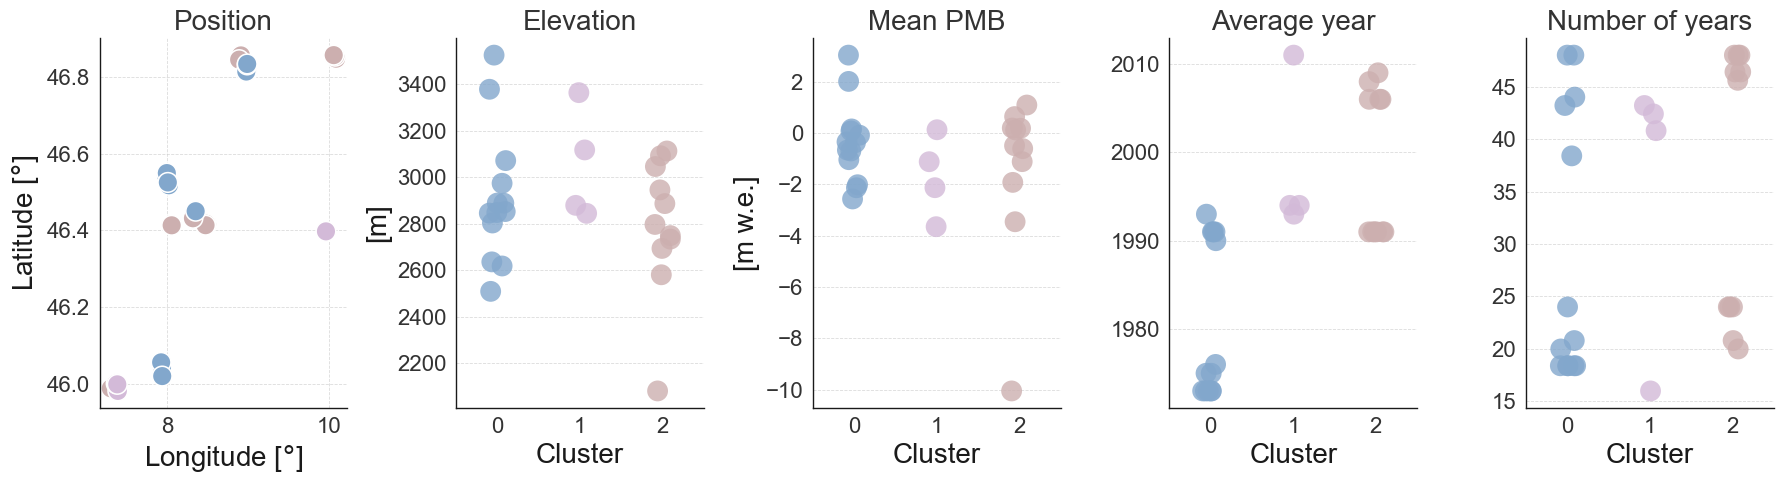

In [48]:
# Get attributes of clusters:
cl_elev, clnb, cl_lat, cl_lon, stakes, glaciers, glshort = [], [], [], [], [], [], []
training_mb, training_y, len_training = [], [], []
for cl_nb in DF_cluster['cluster'].unique():
    cl_stakes = DF_cluster[DF_cluster['cluster'] == cl_nb].index
    for stake in cl_stakes:
        f_stake = read_stake_csv(path_glacattr, f'{stake}_mb.csv')
        cl_elev.append(np.mean(f_stake.height))
        cl_lat.append(np.mean(f_stake.lat))
        cl_lon.append(np.mean(f_stake.lon))
        len_training.append(
            len(var_xg_monthly['feat_train'][stake]['target']) / NUM_FOLDS)
        # mean training mb
        training_mb.append(
            np.mean(var_xg_monthly['feat_train'][stake]['target']))
        training_y.append(
            int(np.mean(var_xg_monthly['feat_train'][stake]['time'])))
        clnb.append(cl_nb)
        stakes.append(stake)
        glaciers.append(re.split('_', stake)[0])
        glshort.append(GL_SHORT[re.split('_', stake)[0]] + '_' +
                       re.split('_', stake)[1])

df_info = pd.DataFrame({
    'elevation': cl_elev,
    'lon': cl_lon,
    'lat': cl_lat,
    'training_mb': training_mb,
    'training_time': training_y,
    'training_length': len_training,
    'cluster': clnb,
    'stakes': stakes,
    'glaciers': glaciers,
    'glshort': glshort
})
df_info["cluster"] = df_info["cluster"].astype("category")

mean_df = pd.DataFrame({
    'cluster':
    range(0, N_c),
    'mean_el':
    df_info.groupby('cluster').mean().elevation,
    'mean_mb':
    df_info.groupby('cluster').mean()['training_mb']
})
stakes_c0 = df_info[df_info['cluster'] == 0].stakes.values
stakes_c1 = df_info[df_info['cluster'] == 1].stakes.values
stakes_c2 = df_info[df_info['cluster'] == 2].stakes.values
print(f'Stakes of cluster 0:\n {stakes_c0}')
print(f'Stakes of cluster 1:\n {stakes_c1}')
print(f'Stakes of cluster 2:\n {stakes_c2}')

plotClusterStats(df_info, mean_df)